In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

np.set_printoptions(suppress=True)
# path = '/Users/tae/Desktop/Project/Dataset/normalize/Normalize6_avg.xlsx'
path = 'https://github.com/taesaksit/project/raw/main/Normalize48.xlsx'

size_feature = 48
size_row = 4



In [174]:
def n_fold():
    

    data = pd.read_excel(path)

    print(data)
    
    dc1 = data[data['class']==1]
    dc2 = data[data['class']==2]
    dc3 = data[data['class']==3]
    dc4 = data[data['class']==4]

    a1 = len(dc1) // 10-1
    a2 = len(dc2) // 10-1
    a3 = len(dc3) // 10-1
    a4 = len(dc4) // 10-1

        

    train = np.empty(10 , dtype='object')
    test = np.empty(10 , dtype='object')

    for cj in range(1,11):
        
        if cj == 10:
            
            stdc1 = (cj-1) * (a1+1)
            ftdc1 = len(dc1)
            
            stdc2 = (cj-1) * (a2+1)
            ftdc2 = len(dc2)
            
            stdc3 = (cj-1) * (a3+1);
            ftdc3 = len(dc3)
            
            stdc4= (cj-1) * (a4+1);
            ftdc4 = len(dc4)
            
        else:
            stdc1 = (cj-1) * (a1+1)
            ftdc1 = stdc1+a1
            
            stdc2 = (cj-1) * (a2+1)
            ftdc2 = stdc2+a2
            
            stdc3 = (cj-1) * (a3+1)
            ftdc3 = stdc3+a3
            
            stdc4 = (cj-1) * (a4+1)
            ftdc4 = stdc4+a4
            
        Dtest1 = dc1[stdc1:ftdc1+1]
        Dtest2 = dc2[stdc2:ftdc2+1]
        Dtest3 = dc3[stdc3:ftdc3+1]
        Dtest4 = dc4[stdc4:ftdc4+1]

        Dtrain1 = dc1.drop(dc1.index[stdc1:ftdc1+1])
        Dtrain2 = dc2.drop(dc2.index[stdc2:ftdc2+1])
        Dtrain3 = dc3.drop(dc3.index[stdc3:ftdc3+1])
        Dtrain4 = dc4.drop(dc4.index[stdc4:ftdc4+1])


        
        
    
        test[cj-1] =  pd.concat([Dtest1, Dtest2,  Dtest3 , Dtest4],ignore_index=True).to_numpy()
        train[cj-1] = pd.concat([Dtrain1,Dtrain2, Dtrain3 ,Dtrain4], ignore_index=True).to_numpy()
        
       
    
    return train , test
    

In [56]:
def initial_pop(size=10):
    
    c_whale = np.empty(size , dtype='object')
    for i in range(size):
        c_whale[i] = np.random.random(size=(size_row,size_feature))
        
    return c_whale


In [82]:
def evaluate_fitness(population, data_train):

    perform = []

    for i in range(len(population)):
        count = 0
        wp = population[i]
        
        for j in range(len(data_train)):
            clone_data = np.tile( data_train[j ,:size_feature] , (size_row,1))
            dis = np.sqrt( np.sum((clone_data - wp)**2 , axis=1)  )
            min_index = np.argmin(dis)
            
            if min_index+1 == data_train[j , size_feature : size_feature+1]:
                count = count + 1
        perform.append((i, count))
                
    score = np.array(perform)
    gbest = population[np.argmax(score[:,1])]
        
    return  score , gbest
    

In [58]:
def sort_value(score):
  
    index = np.argsort(score[:, 1])[::-1]
    top_ten = score[index][:10]
    max_fit = score[index][0, 1]
    indexs = index[:10]

    return  top_ten , max_fit , indexs

In [85]:
def test_model(model , dataTest):
    only_data = dataTest[:,:size_feature]
    class_data = dataTest[:,size_feature:size_feature+1]
    count = 0
    
    for i in range(len(dataTest)):
        md = np.tile(only_data[i] , (size_row,1))
        dis = np.sqrt( np.sum((model - md)**2 , axis=1) )

        
        if np.argmin(dis)+1 == class_data[i]:
            count = count+1
    
    return count

In [202]:
def train_model(population , gbest , train):
    
    best_value = []
    max_iter = 3000
    pxi = 0.5
    imax_fit = 0
    repeat = 0
    count = 0
    threshold = 0.1 * max_iter

    # สร้างตัวแปรสำหรับค่าคงที่
    a_min = 0
    a_max = 1
    w_variation = 0.05
    
    for i in range(max_iter+1): 
        
        a =   (2-2 * (i/max_iter)) 

        r = np.random.random(size=(size_row, size_feature))
        l = (a - 1) * r + 1
#         A = ((2 * a )* r) - a
        A = 2*a*r-a
        C = 2 * r
        
        if repeat >=900:
            break
        
        new_population = np.empty(10, dtype='object')
        
        for j in range(len(population)):
            w_pop = population[j]
            
            if np.random.random() < pxi:
                
                if np.abs(np.sum(A)) > 1:
                    w_rand = np.random.choice(population)
                    D_x = np.sqrt( np.sum( ( (C * w_rand) - w_pop)**2, axis=1  ) ).reshape(size_row,1)                    
                    wpop = w_rand - (A * D_x)
                    
                else:
                    D_x = np.sqrt( np.sum( ( (C * gbest) - w_pop)**2, axis=1  ) ).reshape(size_row,1)
                    wpop = gbest - (A * D_x)
                    
            else:
                w_dist = np.sqrt( np.sum((gbest - w_pop)**2, axis=1 )).reshape(size_row,1)
                wpop = (w_dist * np.exp(l) * np.cos(l * 2 * np.pi)) + gbest 
                
            new_population[j] = np.clip(wpop , a_min=a_min , a_max=a_max) 
        
        # Combined old+new
        combined = np.concatenate((population, new_population))
        score, gbest = evaluate_fitness(combined,train)
        
        #sort data (Fn)
        top_ten , max_fit , new_index = sort_value(score)
        
        #replace population
        population = combined[new_index]
        best_value.append((i,  max_fit))
        
        if imax_fit == max_fit:
            count = count + 1
        else:
            imax_fit = max_fit
            count = 0
            
        #Check Threshold 
        if count > threshold:
            count = 0
            repeat = repeat + 1

            # เพิ่มการเปลี่ยนแปลงตัวแปรในหลายๆ กรณี
            for x in range(1,len(population)):
                if x in {1,2,3}:
                    newW = (w_variation * np.random.random(size=(size_row,size_feature))) - (w_variation/2)
                    population[x] = population[0] + newW
                else:
                    population[x] = np.random.random(size=(size_row,size_feature))
        
    index , value = zip(*best_value)
    plt.figure(figsize=(18,6))
    plt.plot(index,value, marker='o', markersize=2, linewidth=0.8)
    plt.show()

    return population[-1] , best_value[-1][0], best_value[-1][1] , max_iter , best_value


In [61]:
def execute(train,test):
    
    performance = []
    iterValue = []
    graph = []
        
    for i in range(len(test)):

        test_size = len(test[i])
        # 1. initial whale
        population = initial_pop()
        # 2.fitness
        score,gbest = evaluate_fitness(population , train[i])
        # 3.train
        model, lastIter, lastValue, max_iter , best_value = train_model(population,gbest,train[i])
        # 4.test
        
        score_model = test_model(model,test[i])
        graph.append((best_value))
        performance.append([test_size, score_model , np.round(score_model / test_size ,3)])
        iterValue.append([len(train[i]),lastIter,lastValue])
    
    return  np.array(performance), np.array(iterValue) , graph


            x1        x2        x3        x4        x5        x6  class
0     0.829352  0.719641  0.655207  0.787279  0.892345  0.766423      1
1     0.749576  0.620457  0.616348  0.633099  0.651577  0.585224      1
2     0.787311  0.616638  0.601755  0.780521  0.876649  0.840624      1
3     0.651710  0.403171  0.584144  0.576238  0.551100  0.514332      1
4     0.573574  0.546345  0.587541  0.645818  0.625303  0.620998      1
...        ...       ...       ...       ...       ...       ...    ...
4057  0.688005  0.585227  0.533134  0.541975  0.598844  0.468486      4
4058  0.370711  0.320698  0.443537  0.472359  0.548388  0.607332      4
4059  0.283292  0.442692  0.526163  0.369606  0.541421  0.520718      4
4060  0.523063  0.528791  0.484692  0.477448  0.701248  0.643413      4
4061  0.431404  0.420705  0.533431  0.447362  0.532533  0.620821      4

[4062 rows x 7 columns]


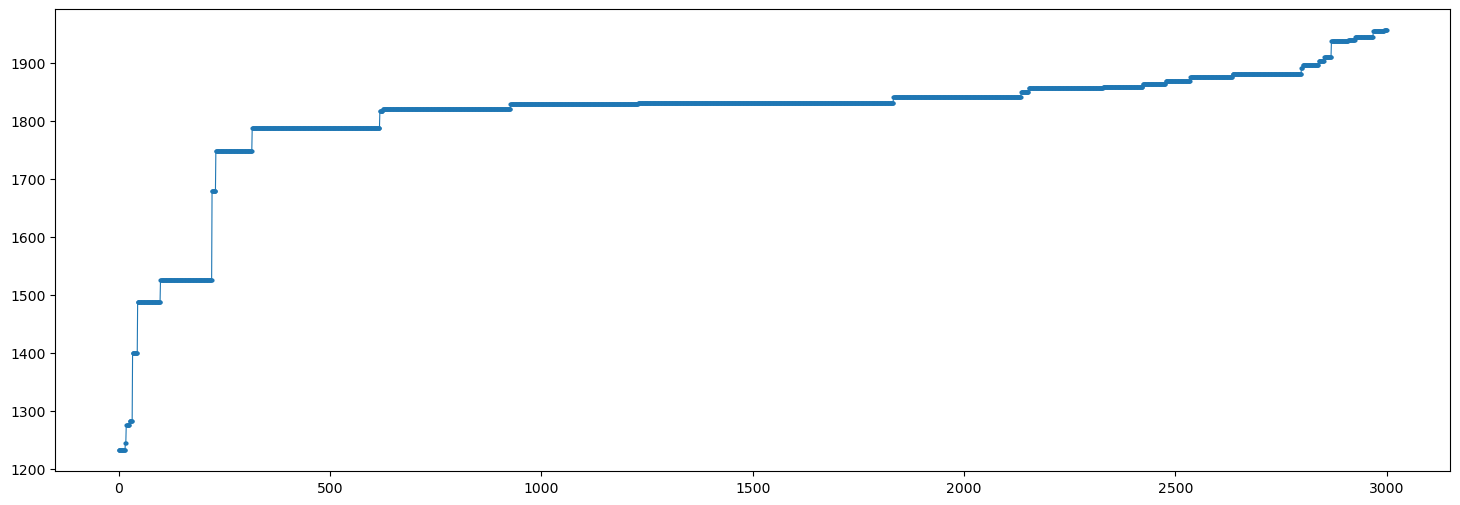

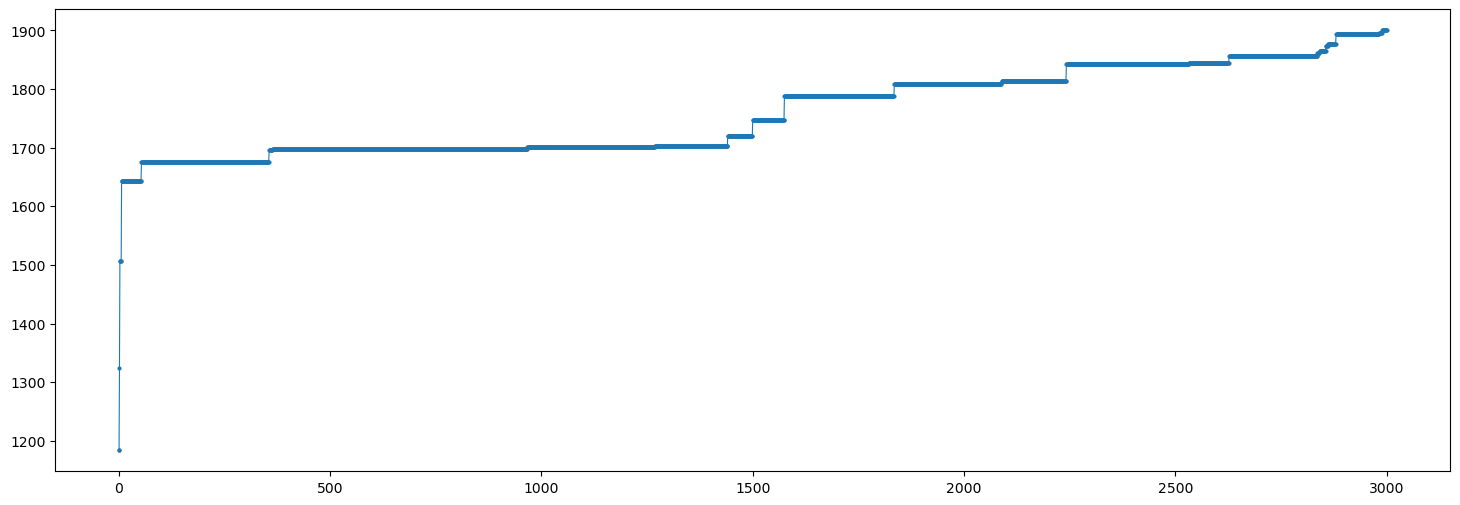

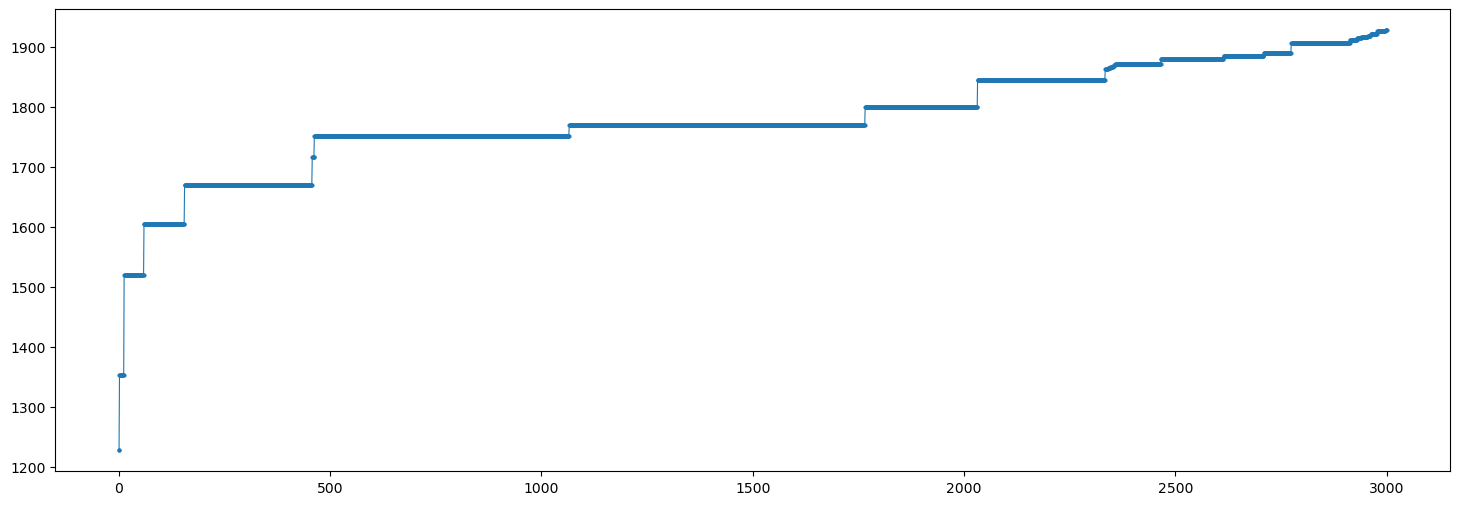

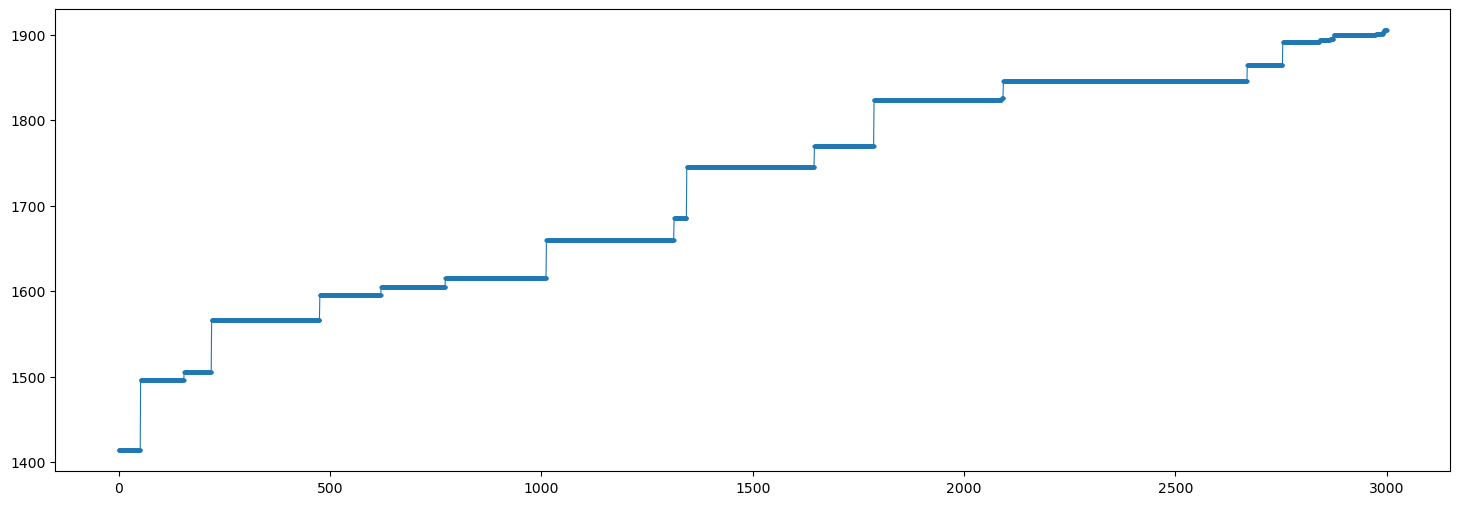

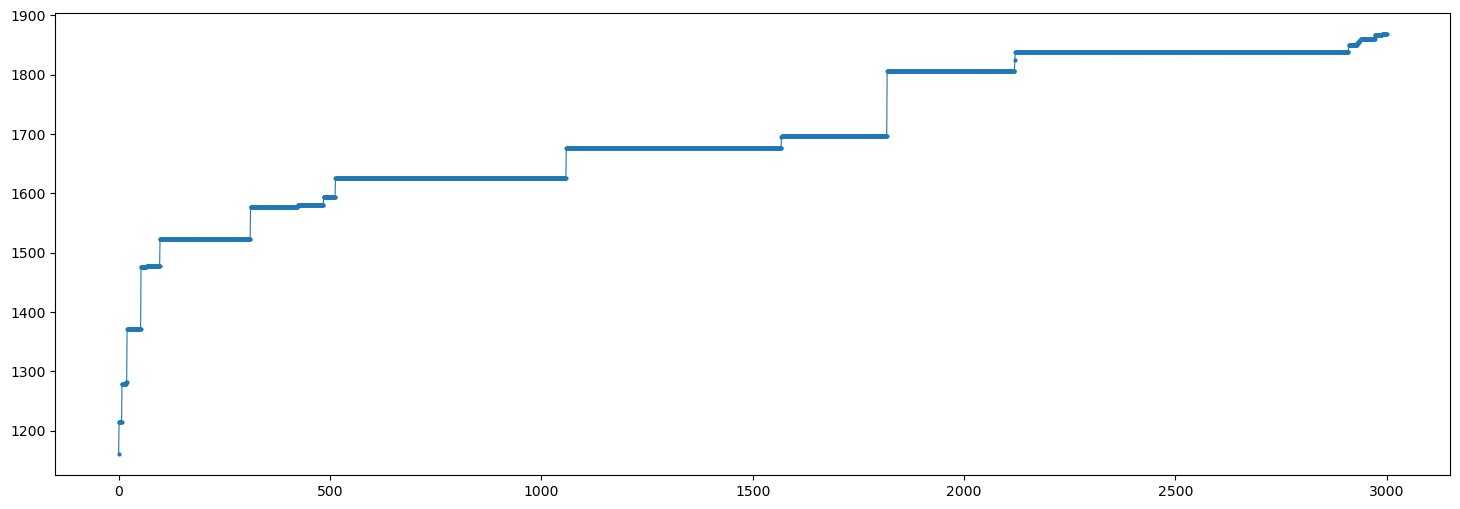

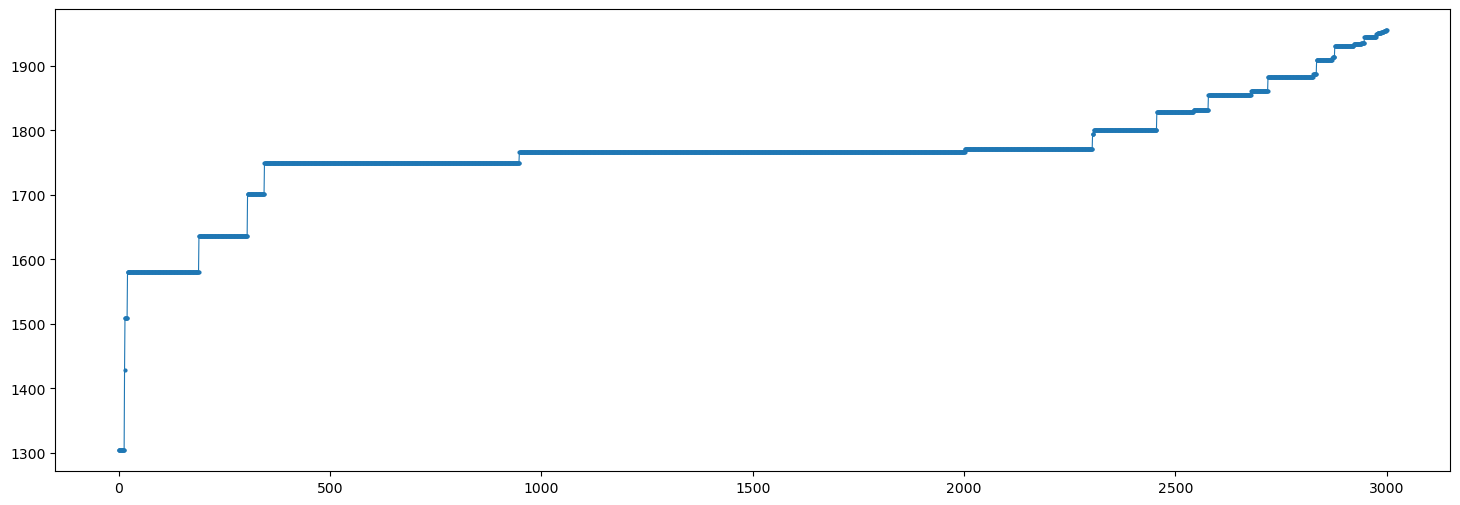

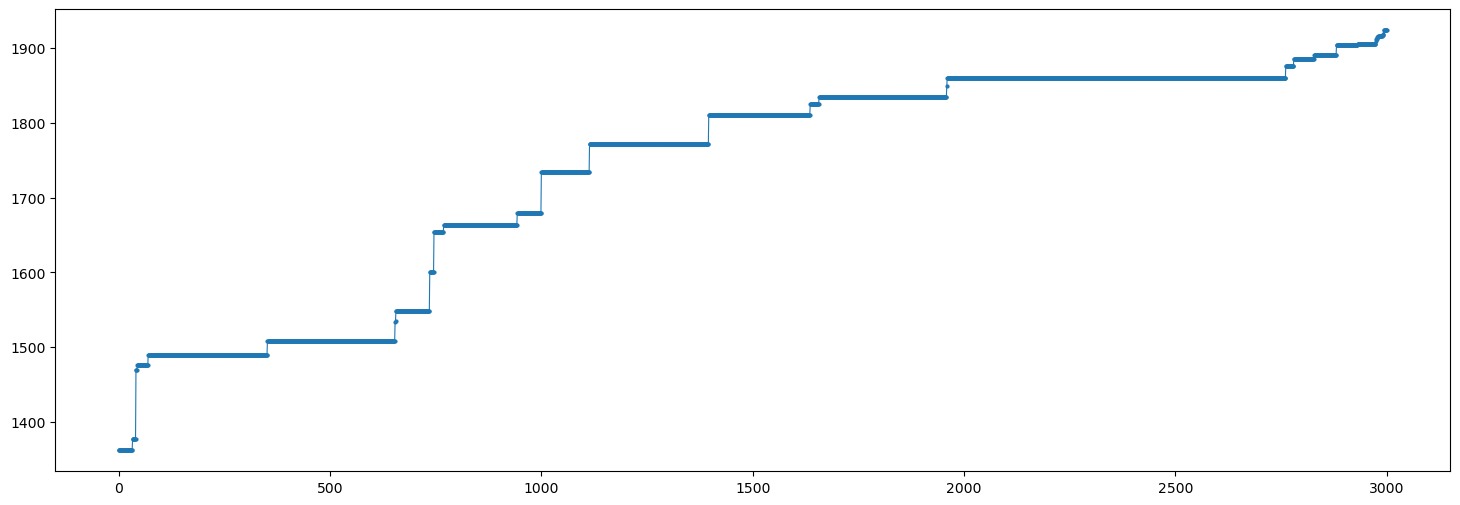

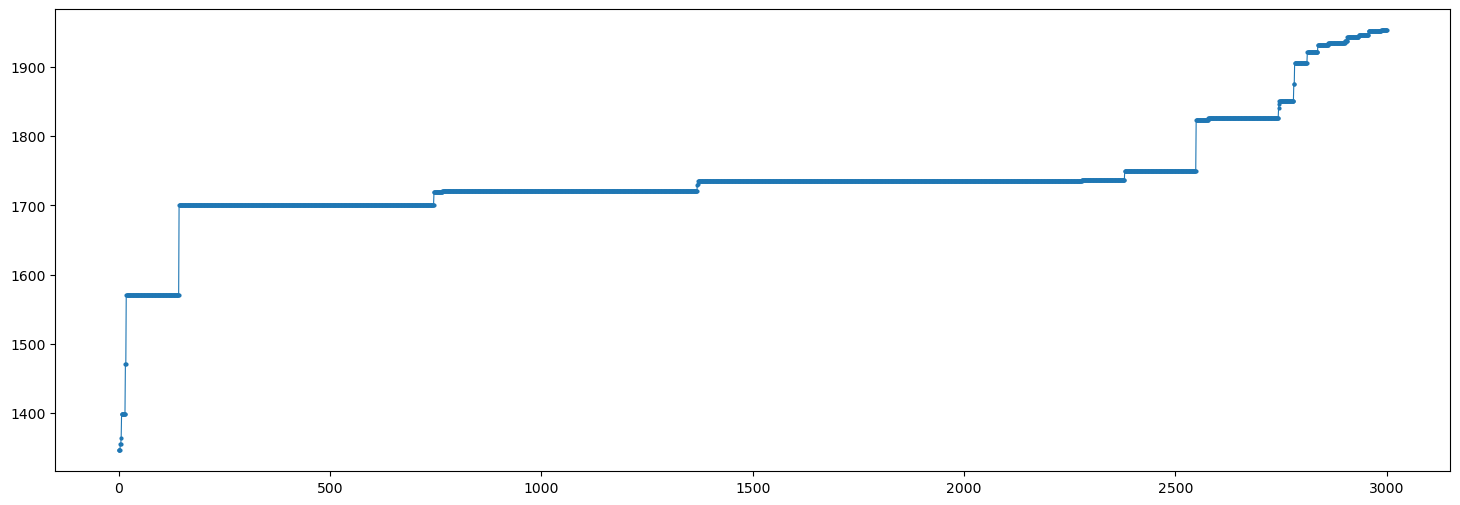

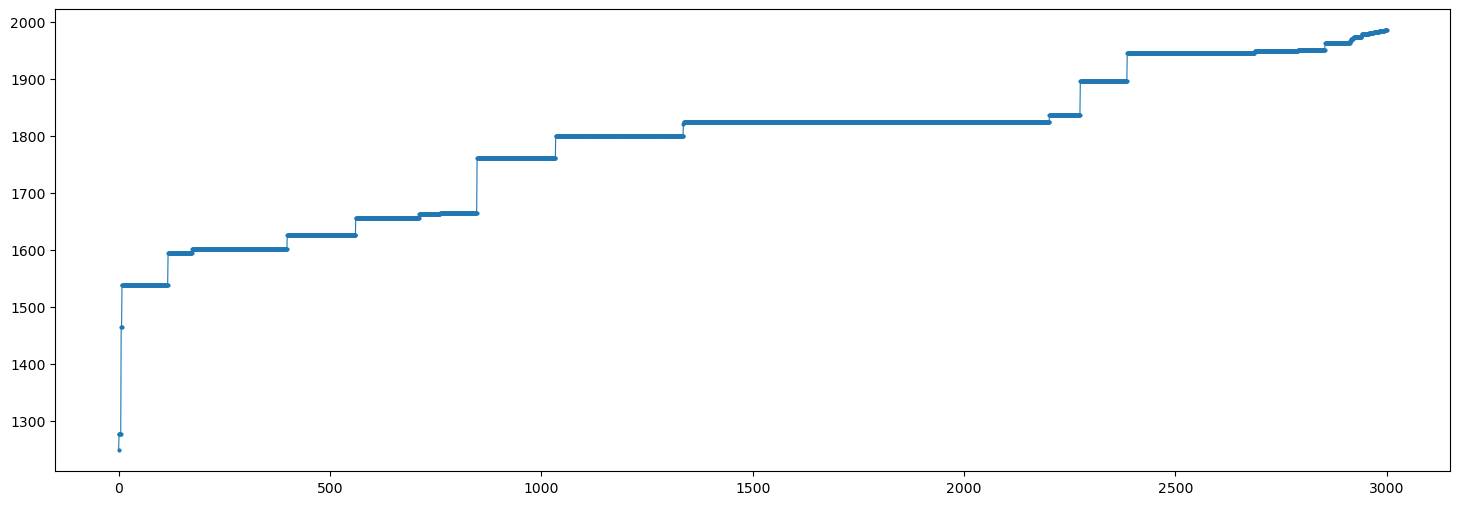

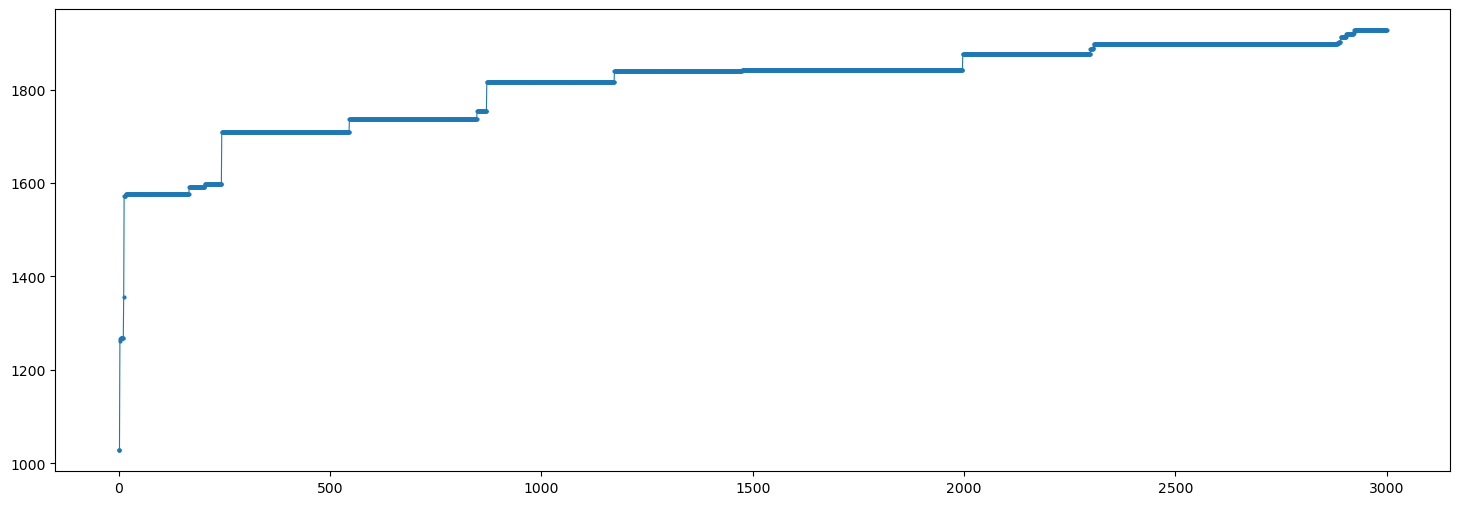

Score Test
[[405.    211.      0.521]
 [405.    208.      0.514]
 [405.    213.      0.526]
 [405.    202.      0.499]
 [405.    202.      0.499]
 [405.    210.      0.519]
 [405.    203.      0.501]
 [405.    215.      0.531]
 [405.    222.      0.548]
 [417.    210.      0.504]] 

Score Train
[[3657 3000 1956]
 [3657 3000 1900]
 [3657 3000 1927]
 [3657 3000 1905]
 [3657 3000 1868]
 [3657 3000 1955]
 [3657 3000 1924]
 [3657 3000 1953]
 [3657 3000 1985]
 [3645 3000 1927]]


In [206]:
# X6
train , test = n_fold()
perform , value , graph = execute(train , test)
print('Score Test')
print(perform , '\n')
print('Score Train')
print(value)

            x1        x2        x3        x4        x5        x6        x7  \
0     0.829352  0.720250  0.712865  0.719713  0.771698  0.581932  0.788236   
1     0.749576  0.621282  0.706234  0.664629  0.564844  0.584343  0.634750   
2     0.787311  0.617471  0.657461  0.705729  0.635674  0.542249  0.781508   
3     0.716362  0.662519  0.686996  0.565740  0.424712  0.453455  0.752421   
4     0.573574  0.547331  0.590707  0.577437  0.535111  0.599767  0.647412   
...        ...       ...       ...       ...       ...       ...       ...   
4057  0.688005  0.586128  0.662935  0.637976  0.428617  0.490990  0.544035   
4058  0.370711  0.322175  0.436385  0.502258  0.467981  0.426091  0.474733   
4059  0.228691  0.327894  0.412076  0.572993  0.594208  0.412546  0.314657   
4060  0.523063  0.529815  0.542111  0.559885  0.519244  0.435710  0.479799   
4061  0.431404  0.421964  0.600370  0.606248  0.400052  0.526338  0.449848   

            x8        x9       x10       x11       x12  class  

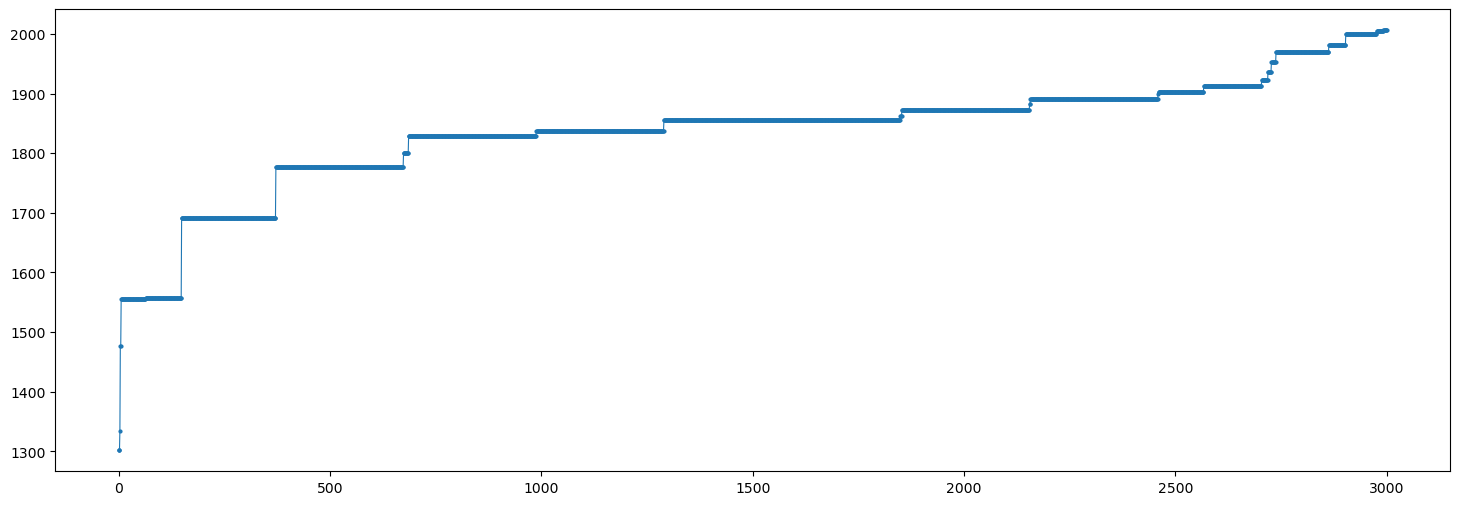

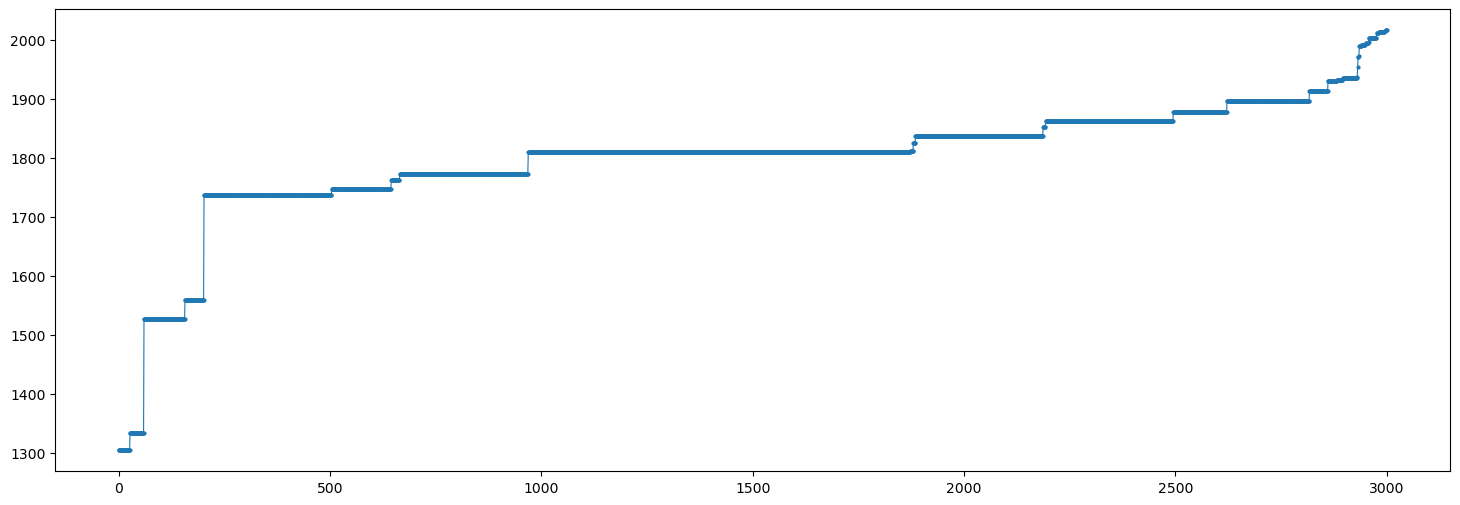

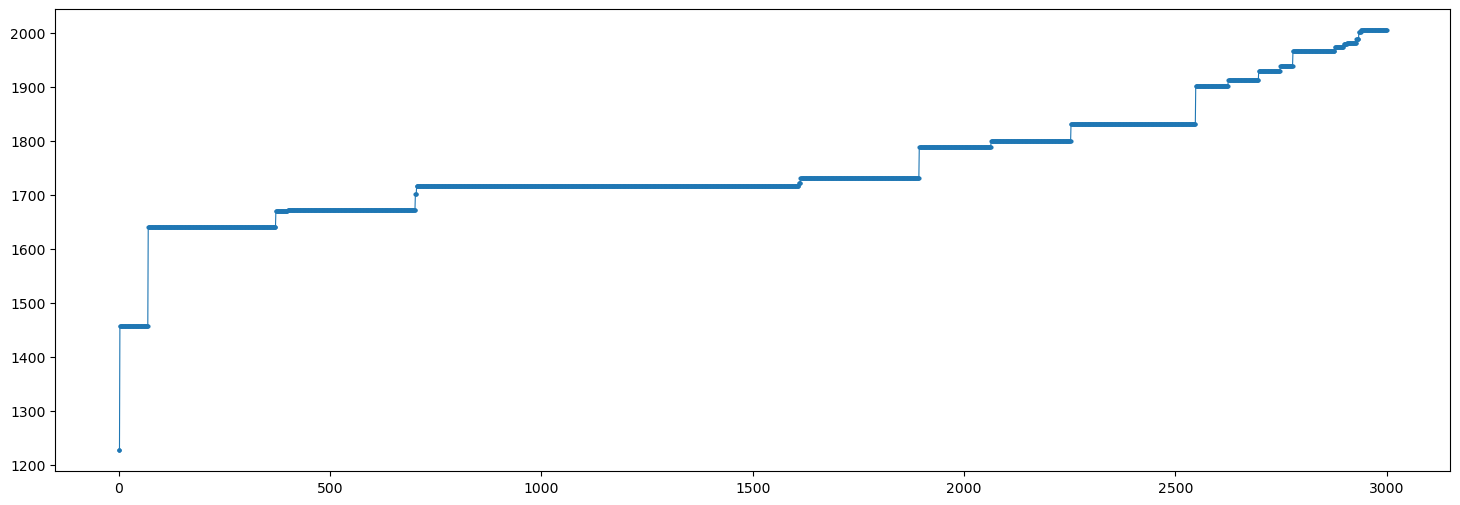

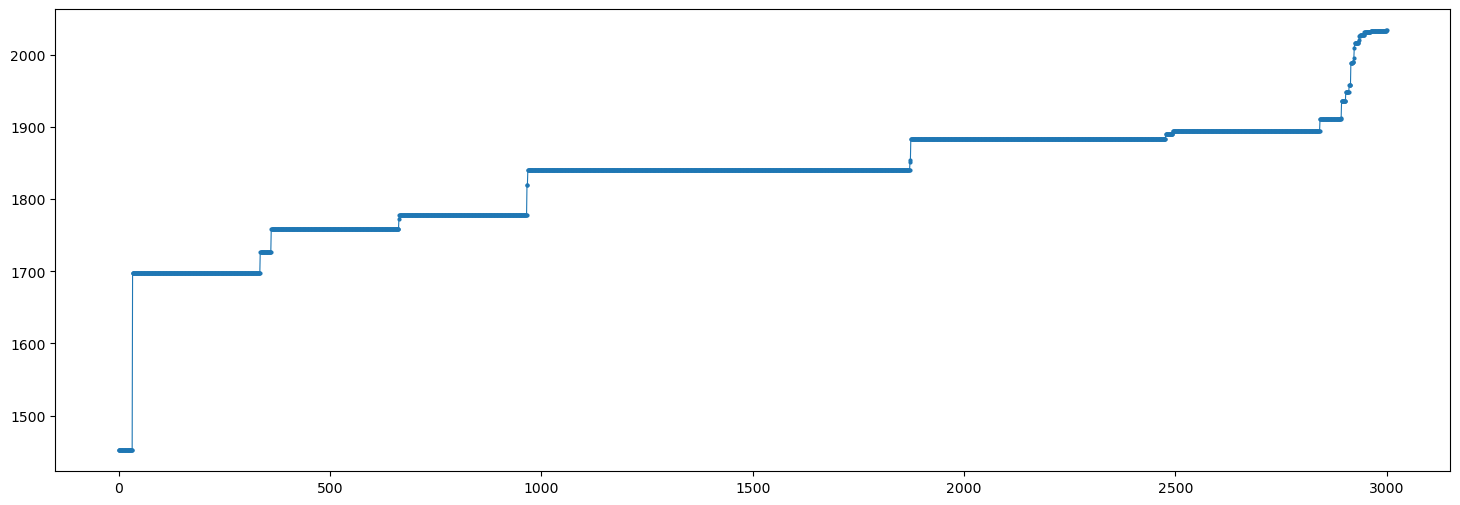

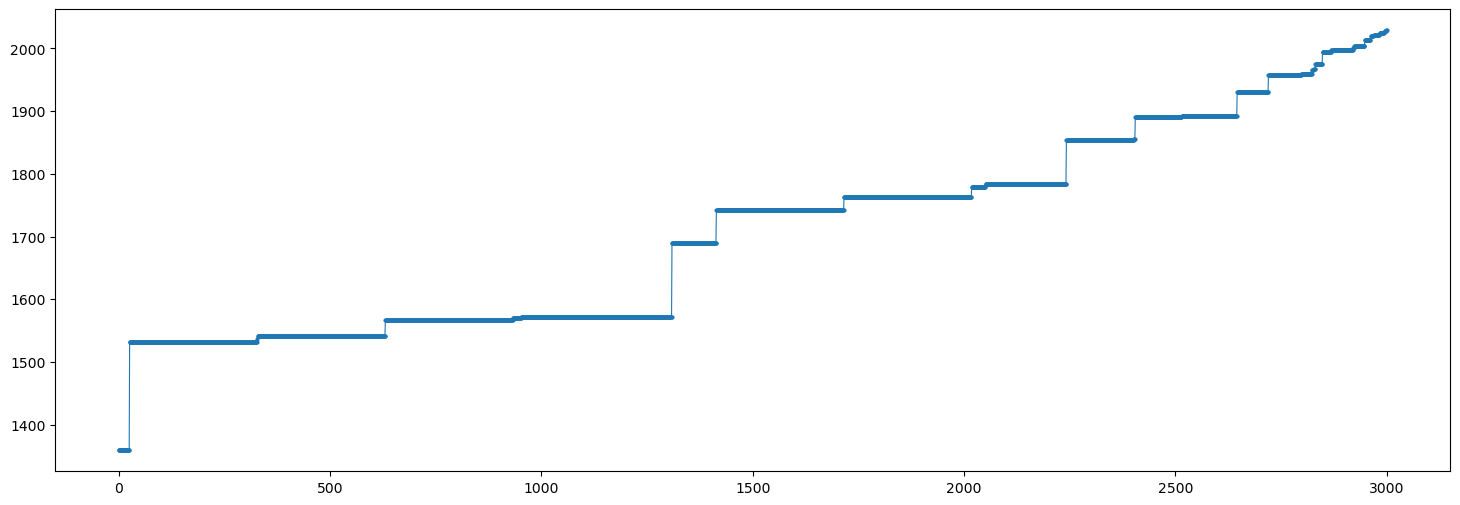

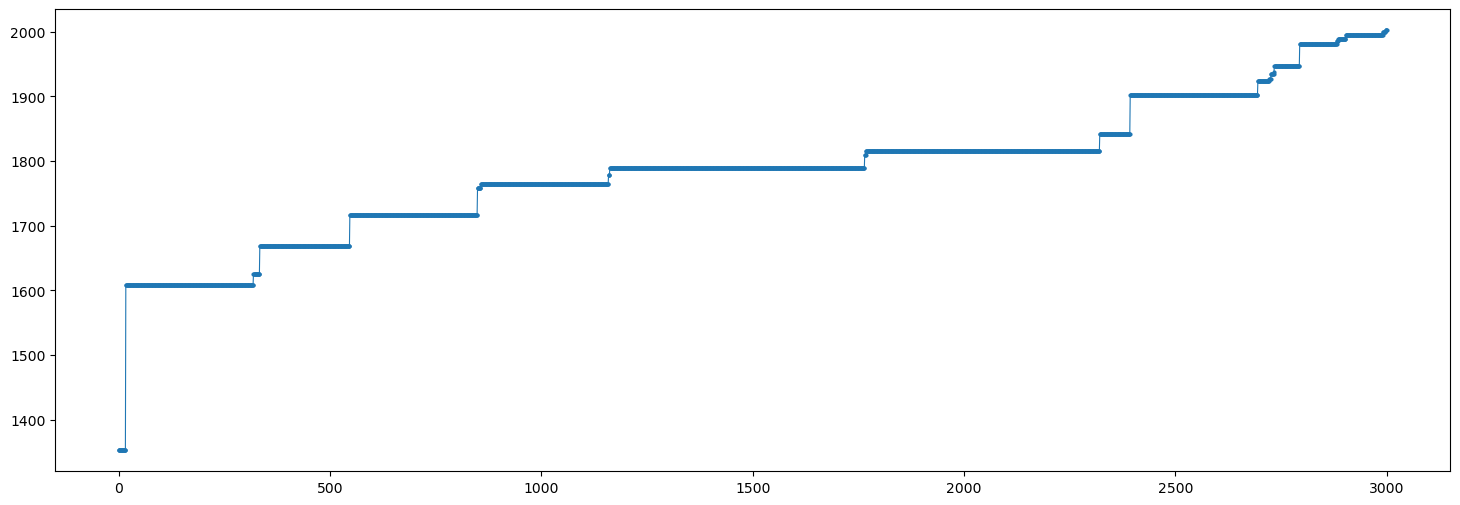

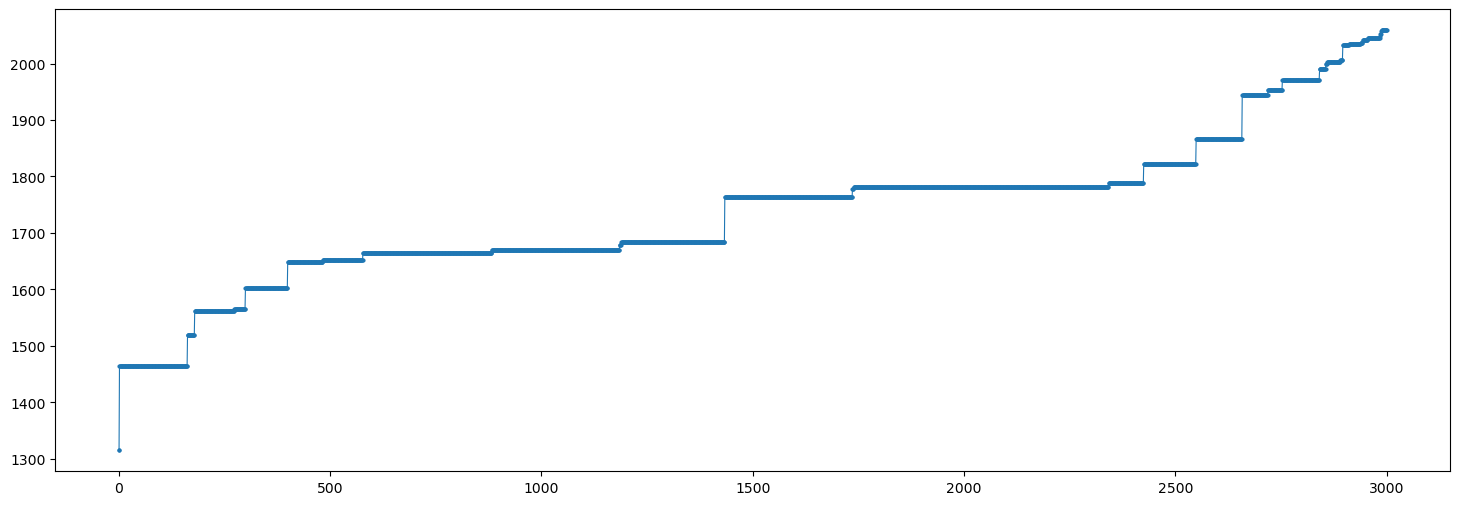

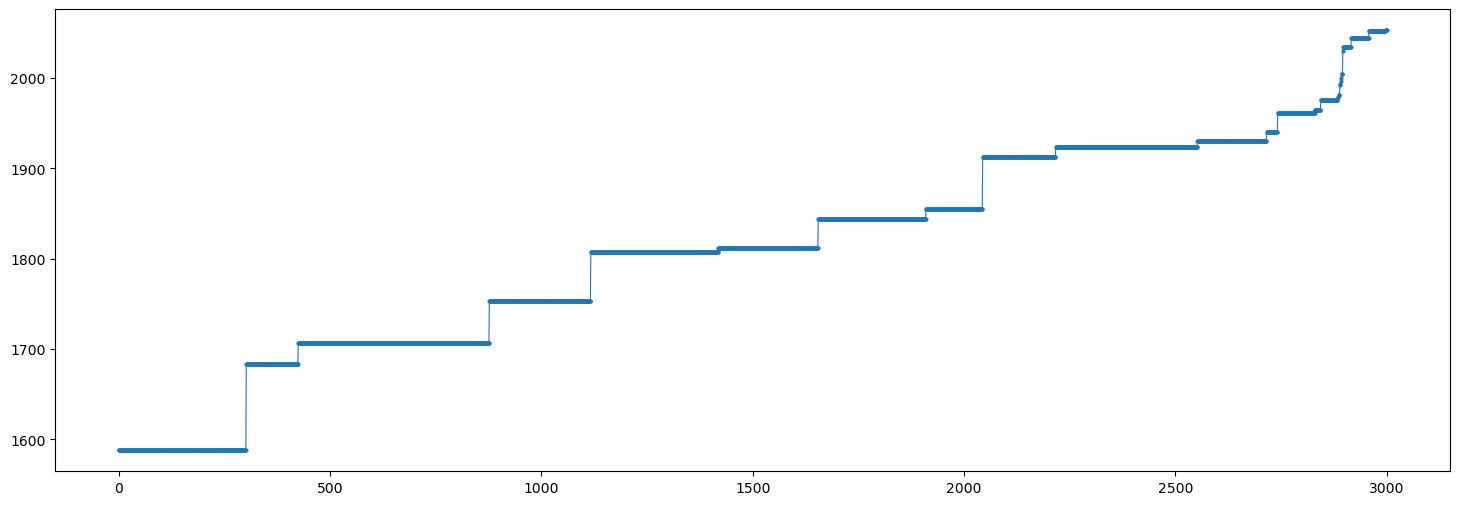

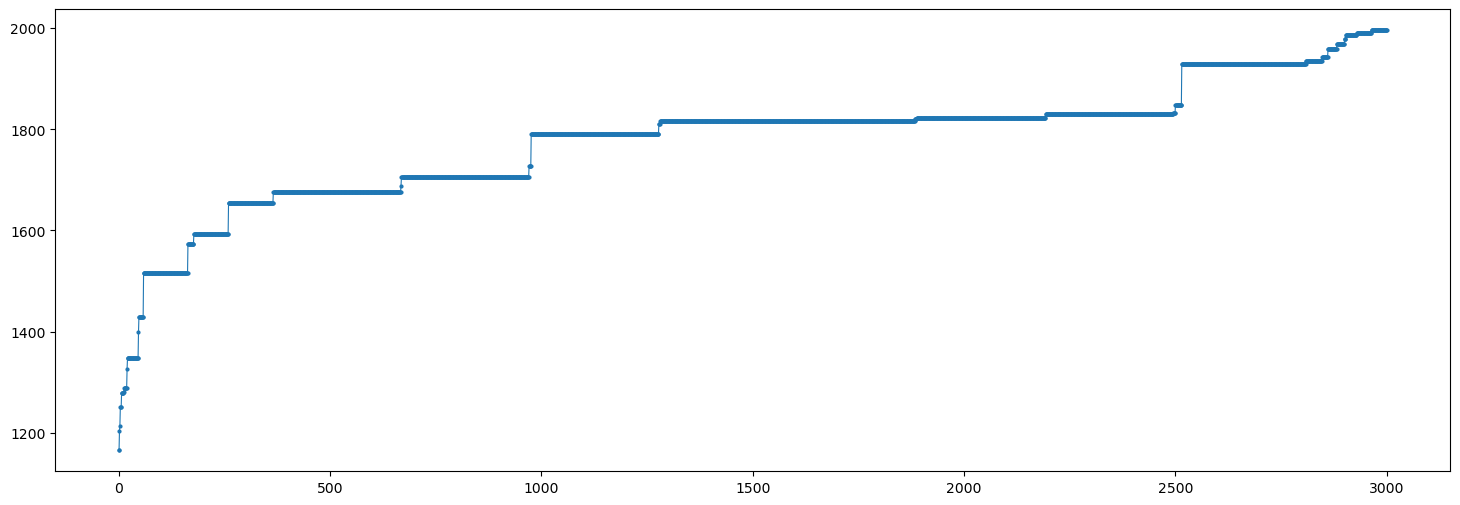

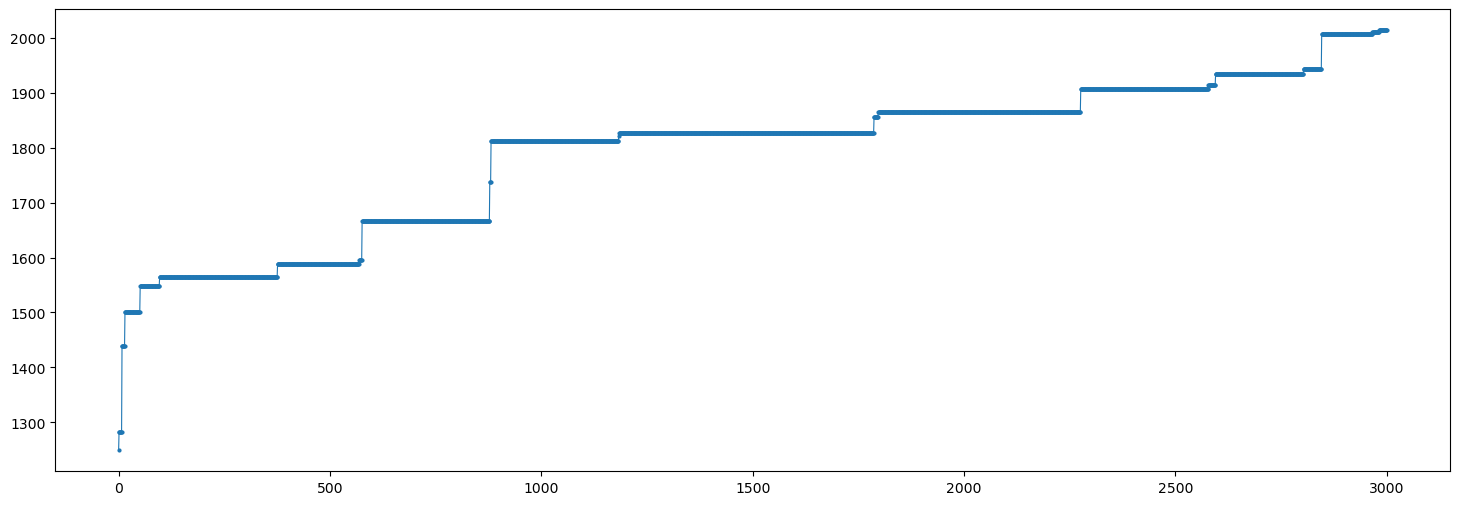

Score Test
[[405.    235.      0.58 ]
 [405.    224.      0.553]
 [405.    225.      0.556]
 [405.    211.      0.521]
 [405.    213.      0.526]
 [405.    224.      0.553]
 [405.    227.      0.56 ]
 [405.    214.      0.528]
 [405.    234.      0.578]
 [417.    210.      0.504]] 

Score Train
[[3657 3000 2006]
 [3657 3000 2016]
 [3657 3000 2005]
 [3657 3000 2034]
 [3657 3000 2029]
 [3657 3000 2002]
 [3657 3000 2059]
 [3657 3000 2053]
 [3657 3000 1996]
 [3645 3000 2014]]


In [208]:
# X12
train , test = n_fold()
perform , value , graph = execute(train , test)
print('Score Test')
print(perform , '\n')
print('Score Train')
print(value)

            x1        x2        x3        x4        x5        x6        x7  \
0     0.845778  0.836034  0.810786  0.758002  0.701107  0.685154  0.710336   
1     0.780137  0.757514  0.706996  0.611915  0.596062  0.630097  0.675836   
2     0.899907  0.780504  0.688024  0.665672  0.615636  0.560783  0.609360   
3     0.737552  0.735033  0.697596  0.663988  0.653888  0.665735  0.735024   
4     0.686849  0.553114  0.506727  0.546749  0.545775  0.543573  0.588304   
...        ...       ...       ...       ...       ...       ...       ...   
4057  0.724123  0.709243  0.652376  0.632772  0.571094  0.545148  0.676348   
4058  0.463109  0.346747  0.348477  0.303530  0.315971  0.340497  0.414575   
4059  0.325175  0.224029  0.193676  0.315549  0.349591  0.308877  0.349510   
4060  0.519998  0.523479  0.539118  0.582598  0.534271  0.457695  0.504919   
4061  0.607951  0.414525  0.286964  0.313491  0.437362  0.496755  0.567848   

            x8        x9       x10  ...       x16       x17    

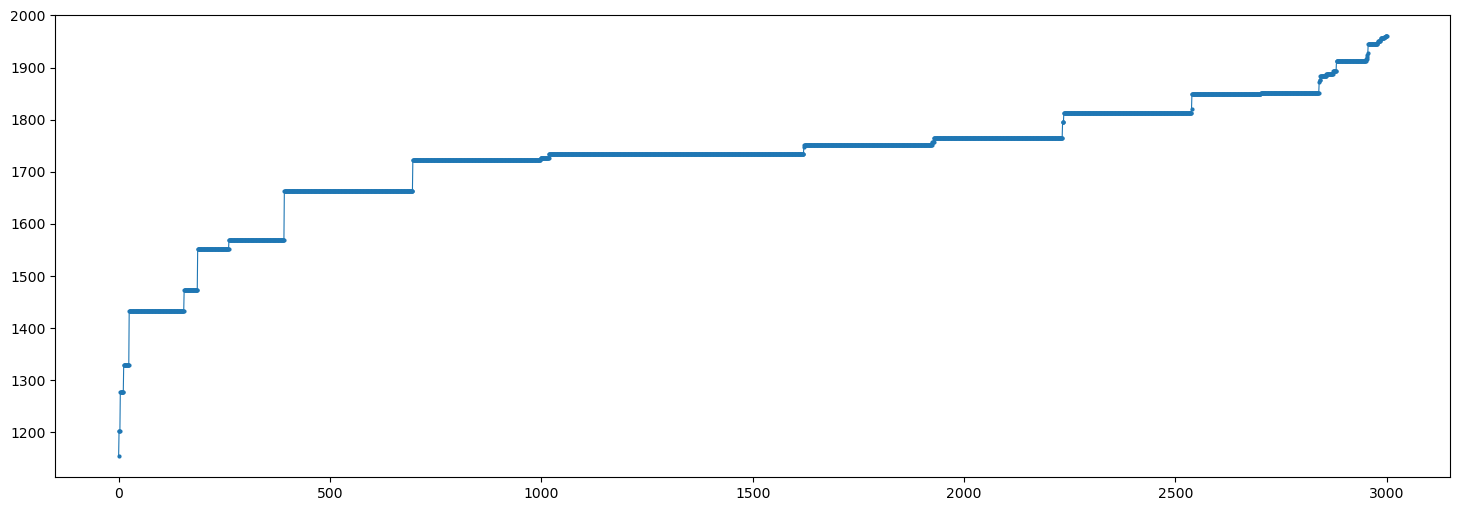

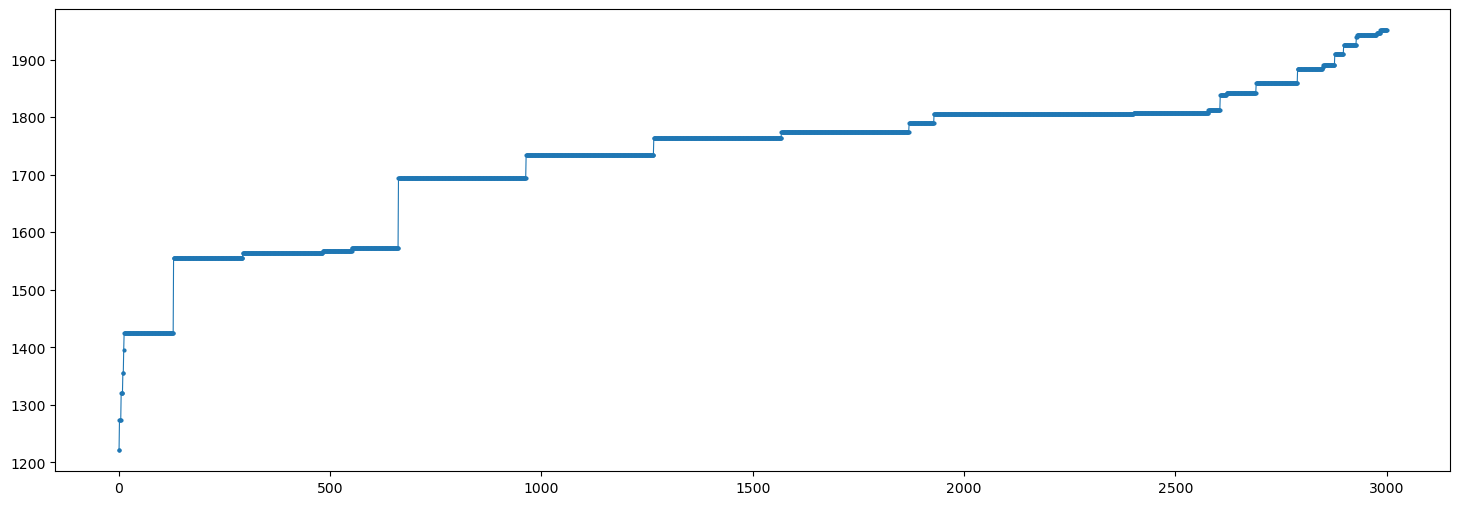

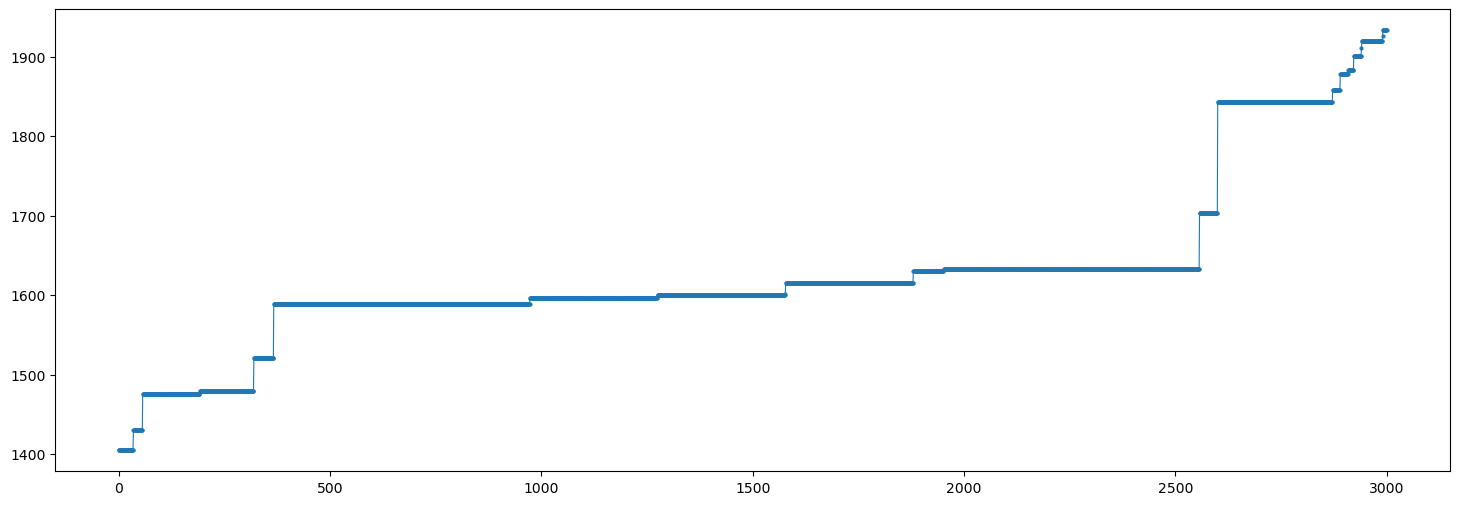

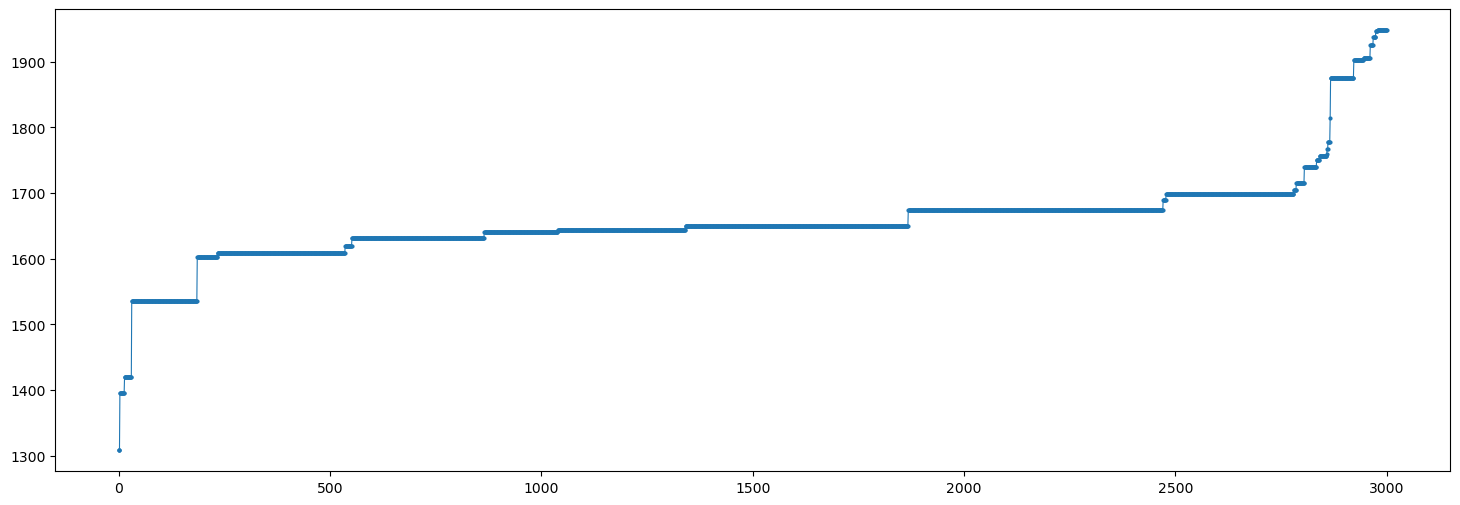

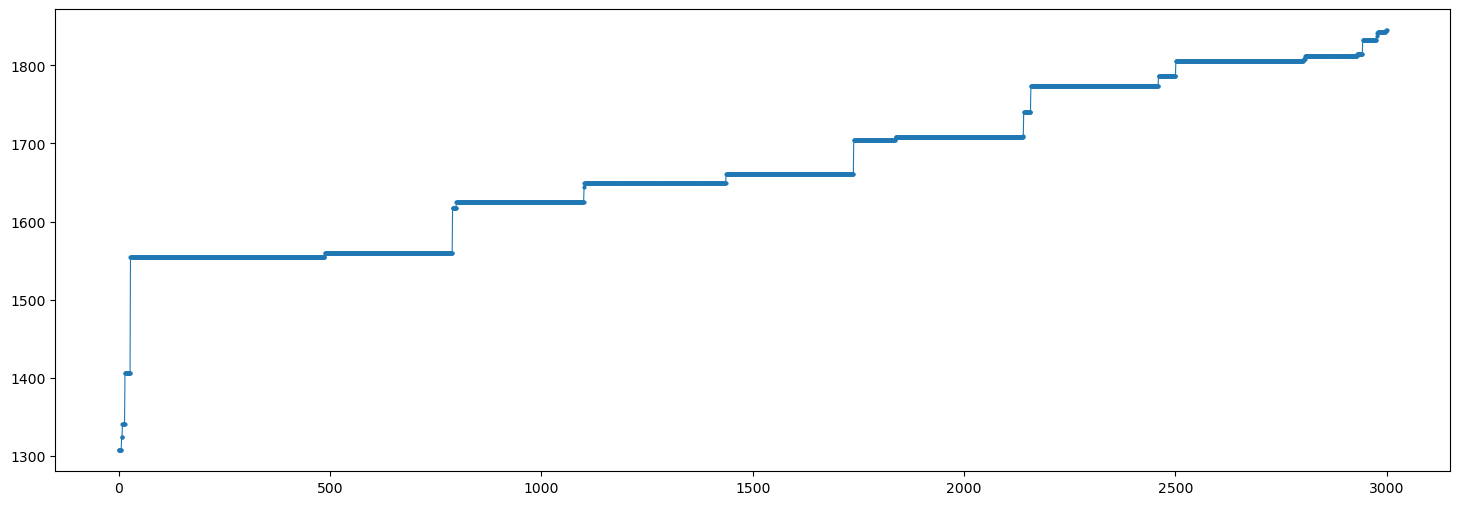

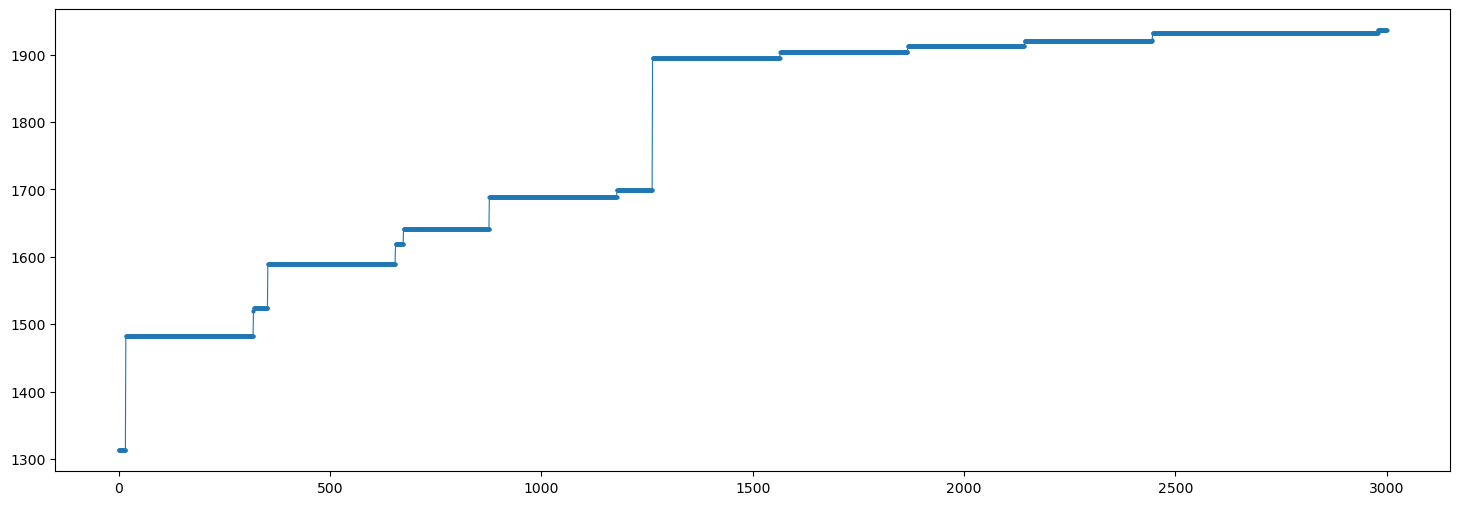

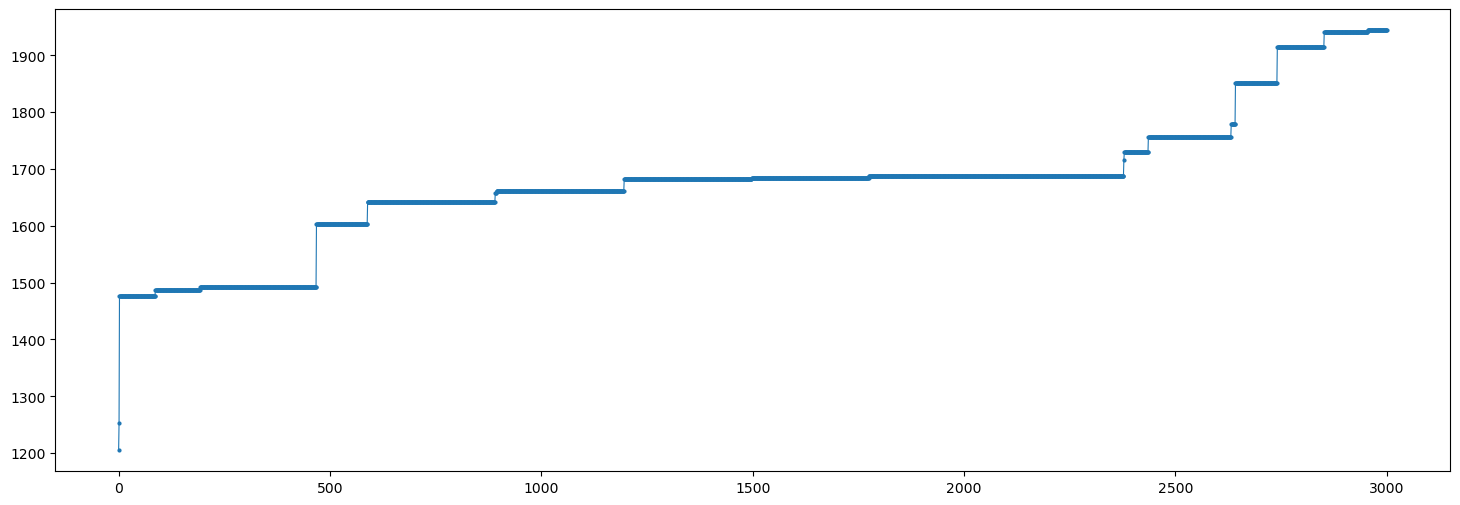

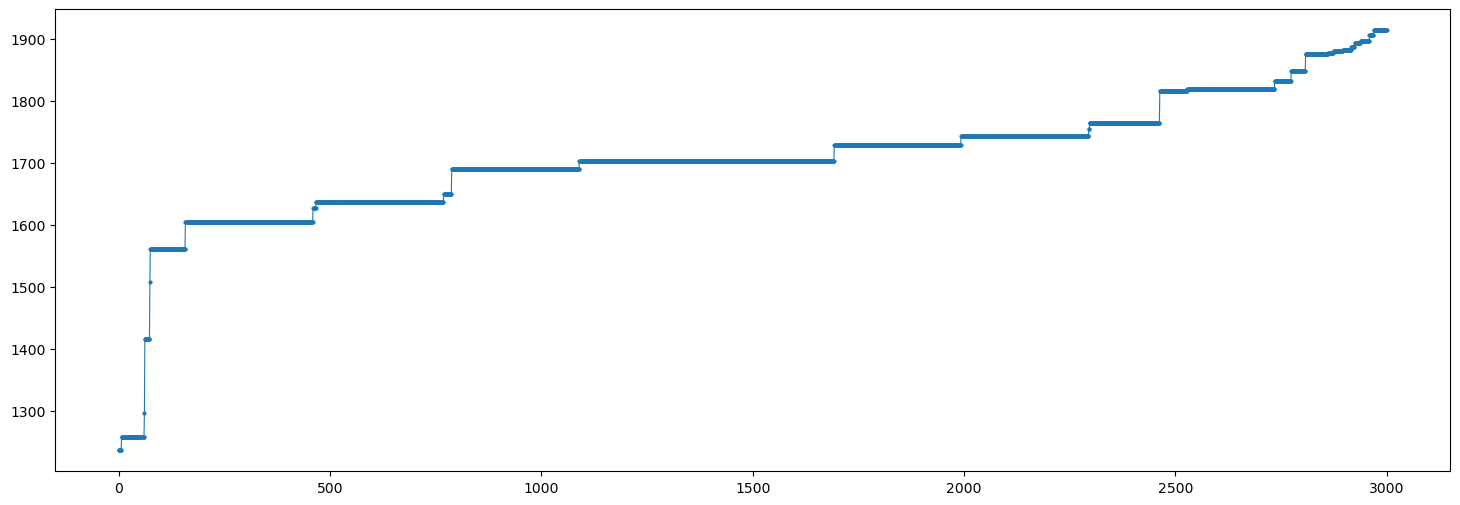

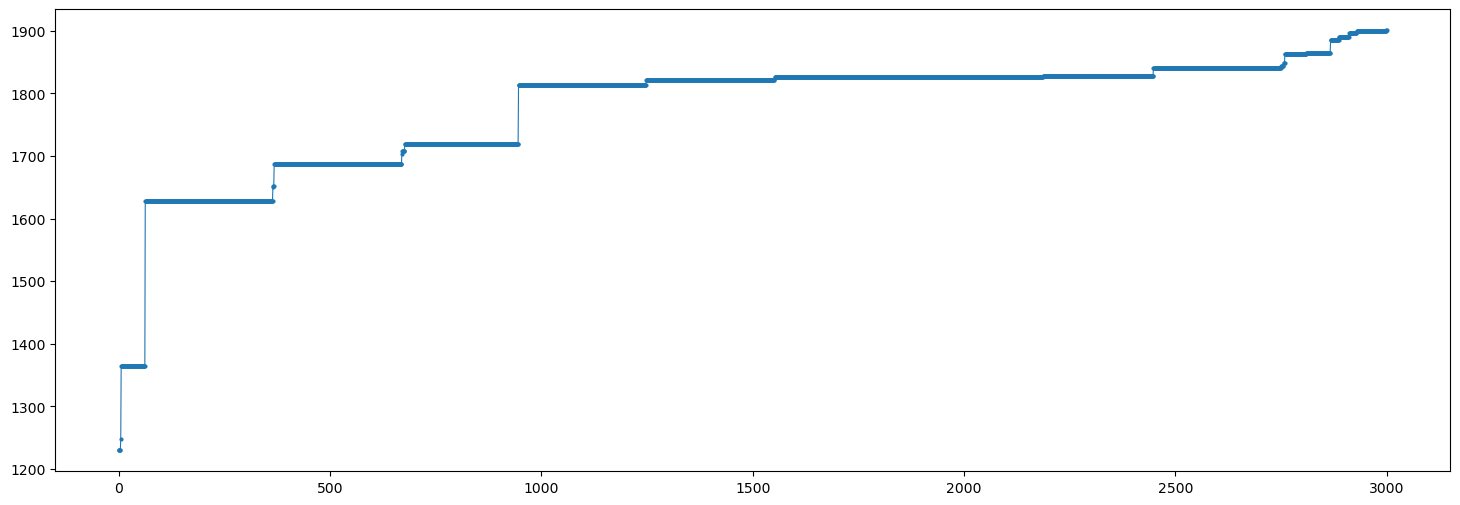

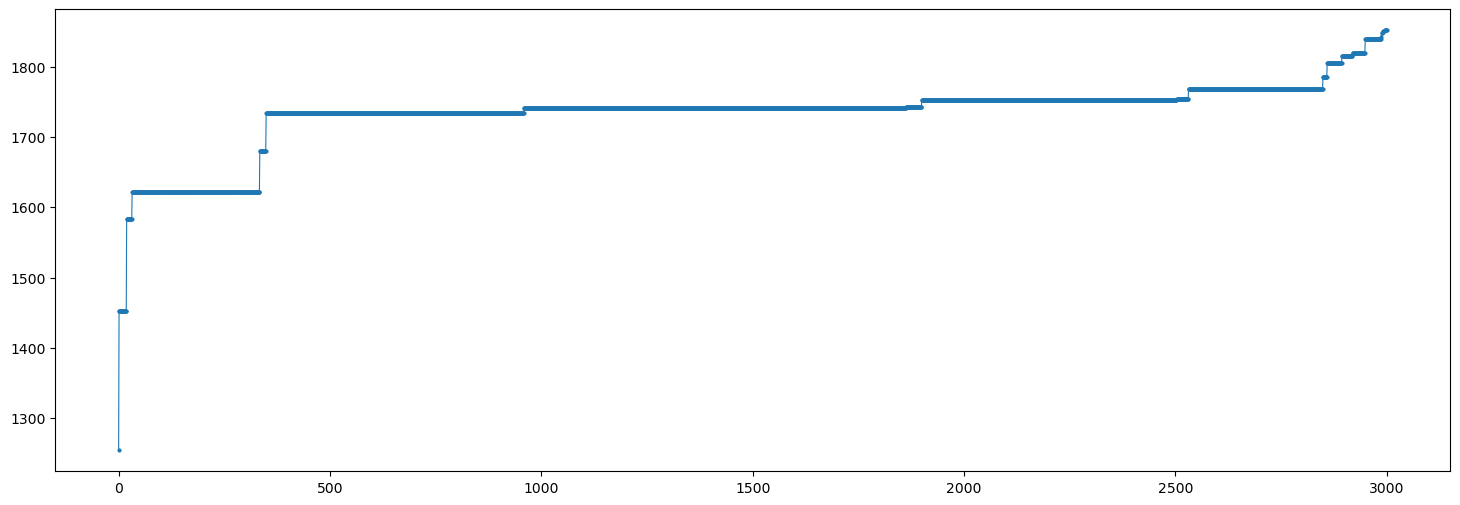

Score Test
[[405.    206.      0.509]
 [405.    213.      0.526]
 [405.    207.      0.511]
 [405.    208.      0.514]
 [405.    194.      0.479]
 [405.    210.      0.519]
 [405.    203.      0.501]
 [405.    205.      0.506]
 [405.    212.      0.523]
 [417.    197.      0.472]] 

Score Train
[[3657 3000 1960]
 [3657 3000 1951]
 [3657 3000 1933]
 [3657 3000 1948]
 [3657 3000 1845]
 [3657 3000 1936]
 [3657 3000 1944]
 [3657 3000 1914]
 [3657 3000 1901]
 [3645 3000 1852]]


In [210]:
# X24
train , test = n_fold()
perform , value , graph = execute(train , test)
print('Score Test')
print(perform , '\n')
print('Score Train')
print(value)

            x1        x2        x3        x4        x5        x6        x7  \
0     0.845778  0.836034  0.809063  0.758002  0.701107  0.685154  0.710336   
1     0.780137  0.757514  0.705493  0.611915  0.596062  0.630097  0.675836   
2     0.899907  0.780504  0.686562  0.665672  0.615636  0.560783  0.609360   
3     0.737552  0.735033  0.696113  0.663988  0.653888  0.665735  0.735024   
4     0.686849  0.553114  0.505650  0.546749  0.545775  0.543573  0.588304   
...        ...       ...       ...       ...       ...       ...       ...   
4057  0.724123  0.709243  0.650989  0.632772  0.571094  0.545148  0.676348   
4058  0.463109  0.346747  0.347736  0.303530  0.315971  0.340497  0.414575   
4059  0.325175  0.224029  0.193264  0.315549  0.349591  0.308877  0.349510   
4060  0.519998  0.523479  0.537972  0.582598  0.534271  0.457695  0.504919   
4061  0.607951  0.414525  0.286354  0.313491  0.437362  0.496755  0.567848   

            x8        x9       x10  ...       x40       x41    

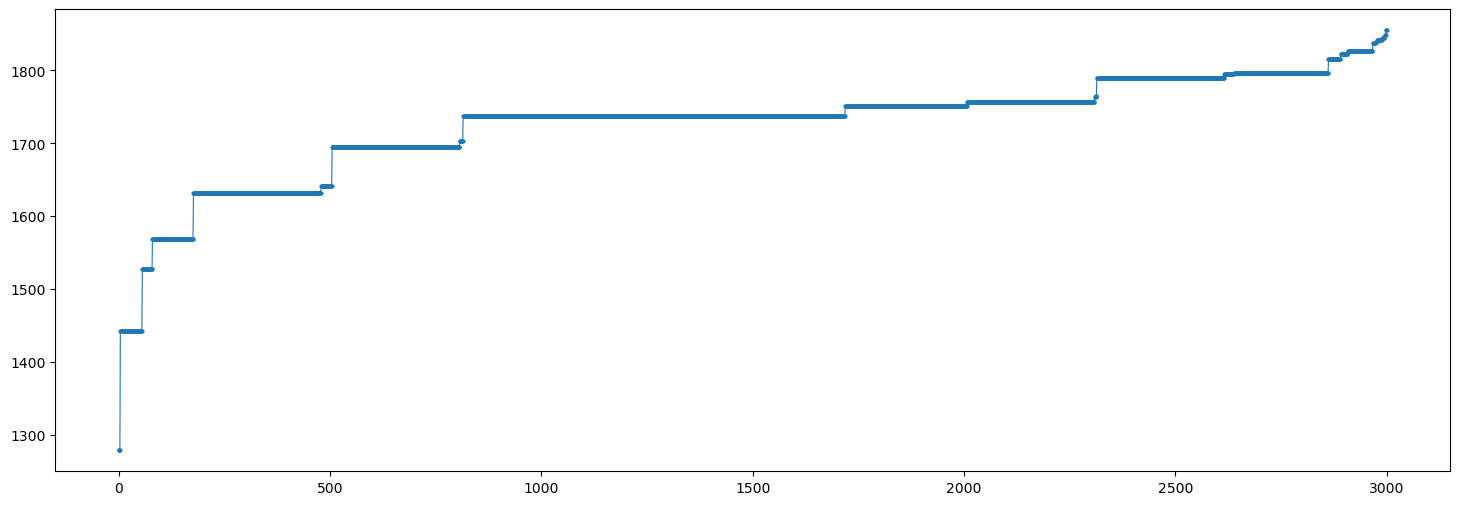

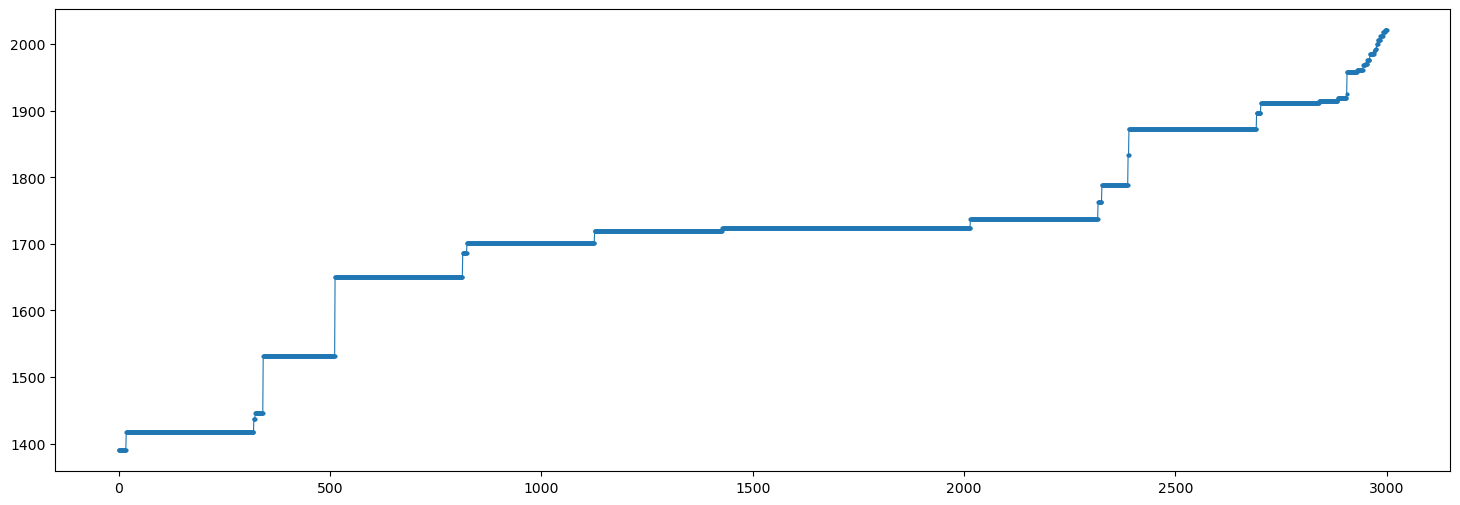

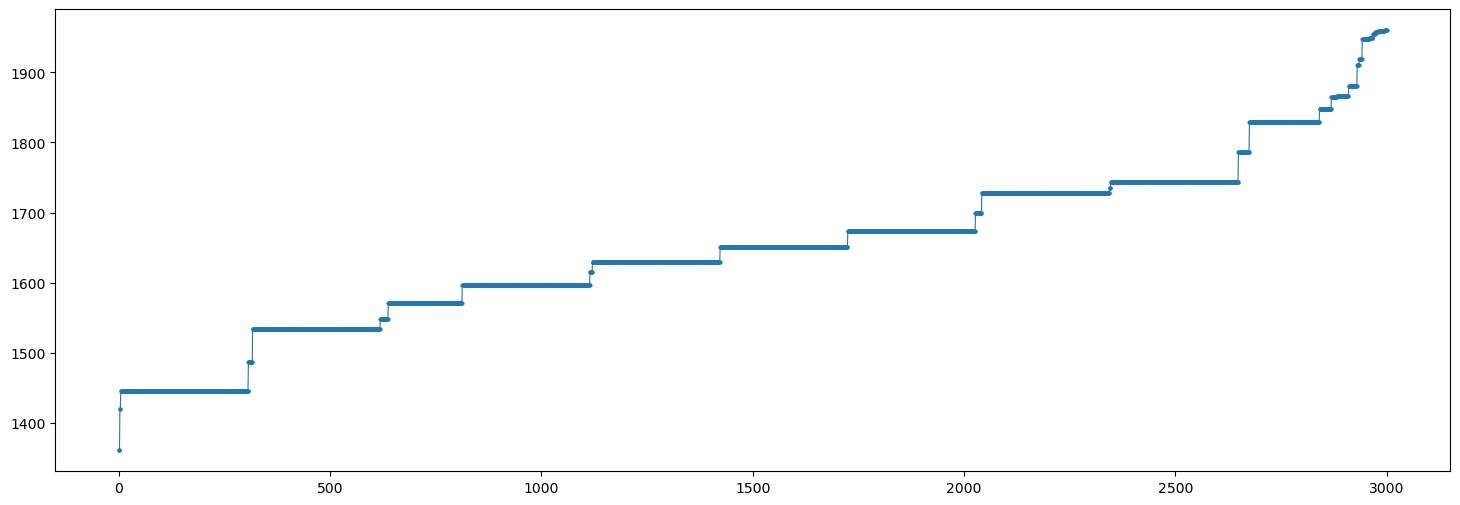

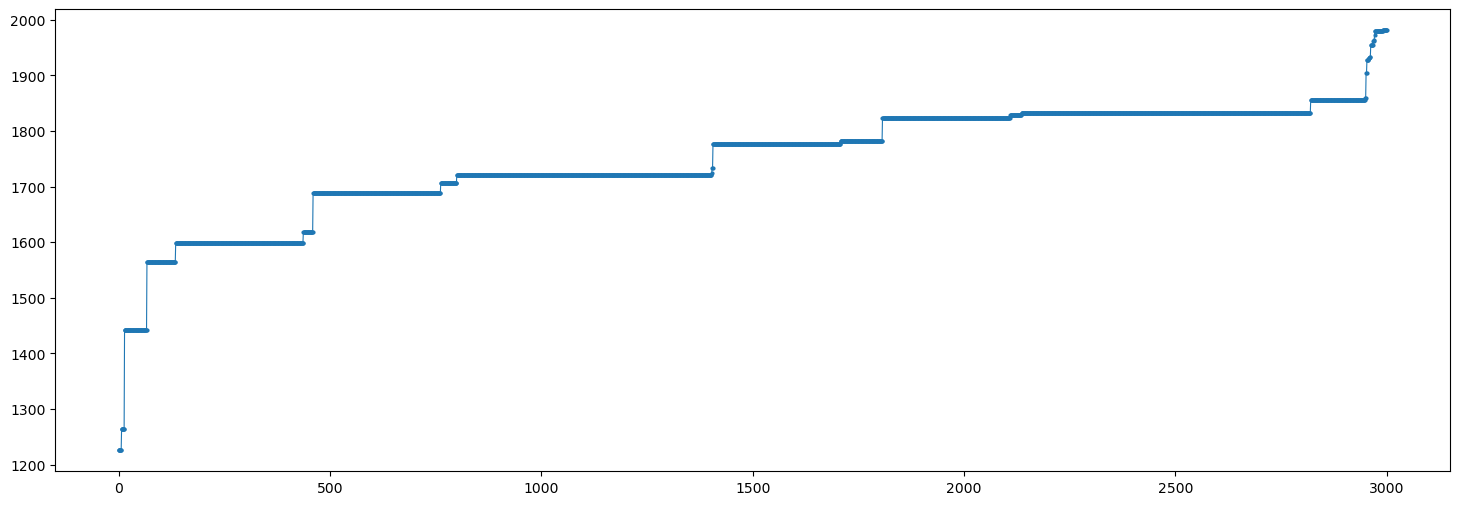

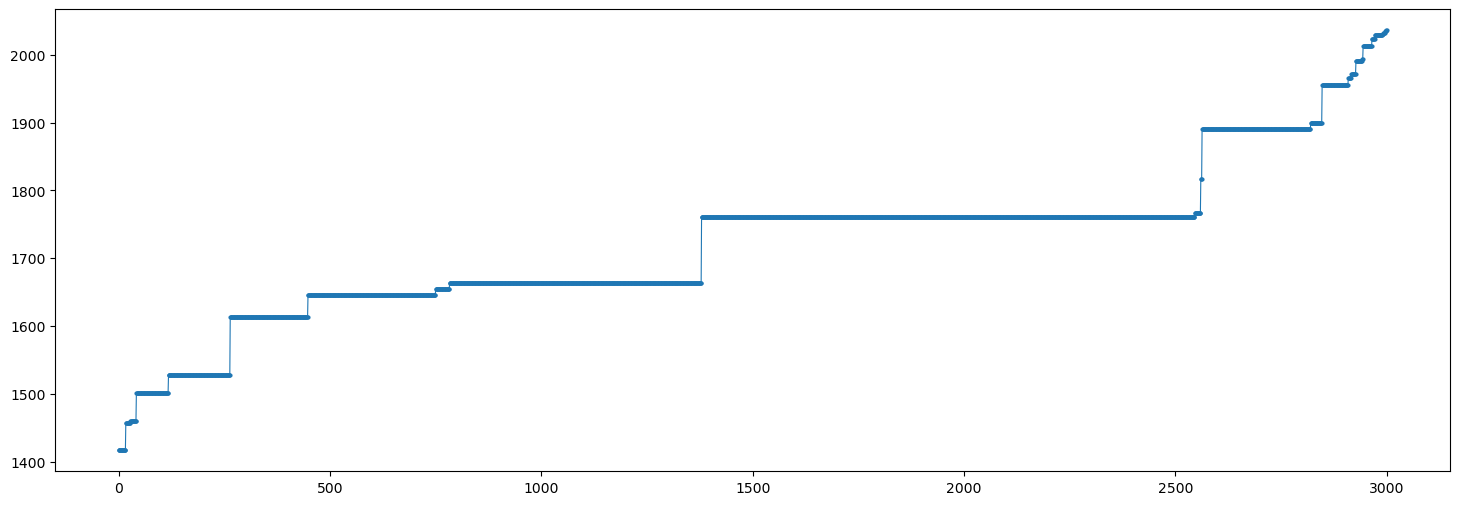

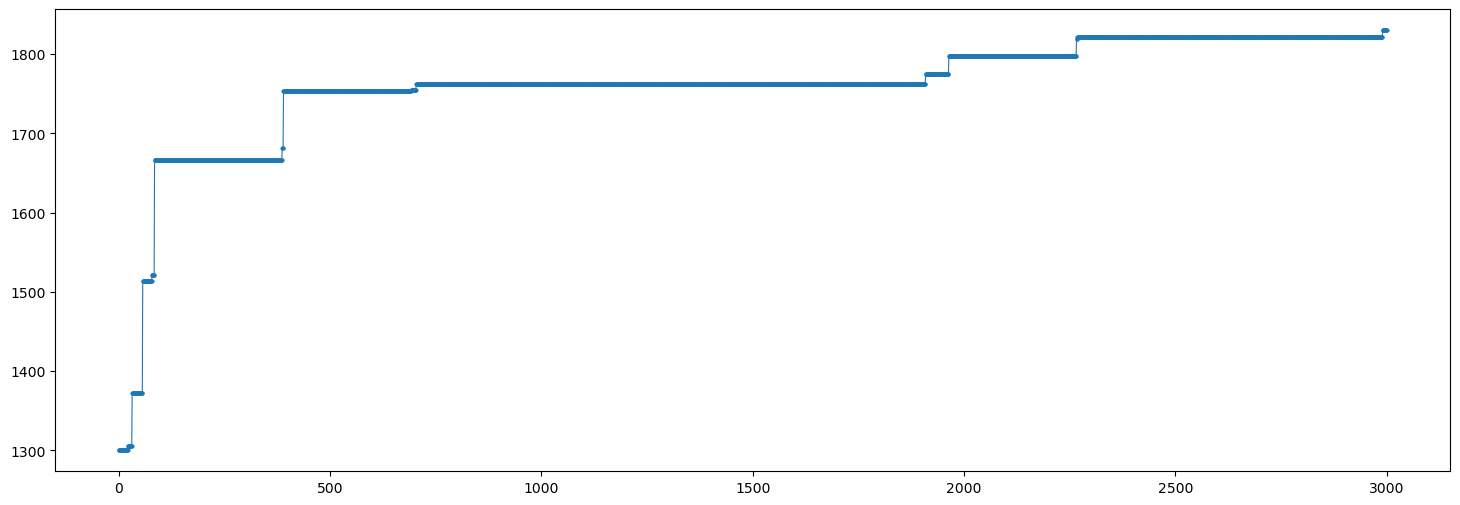

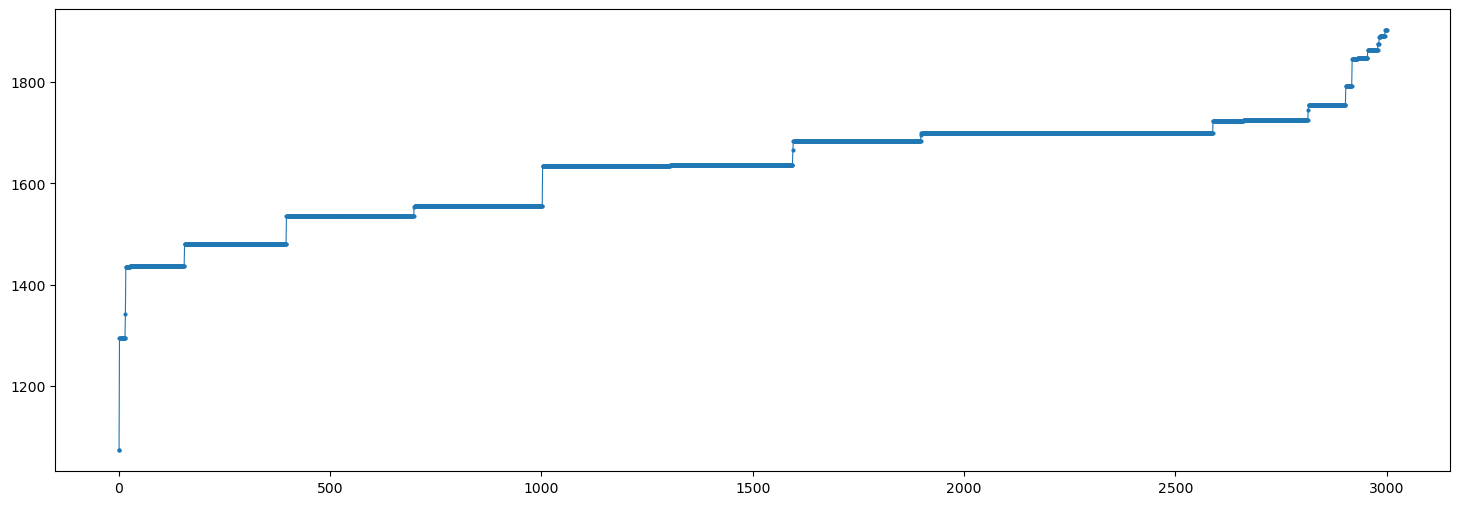

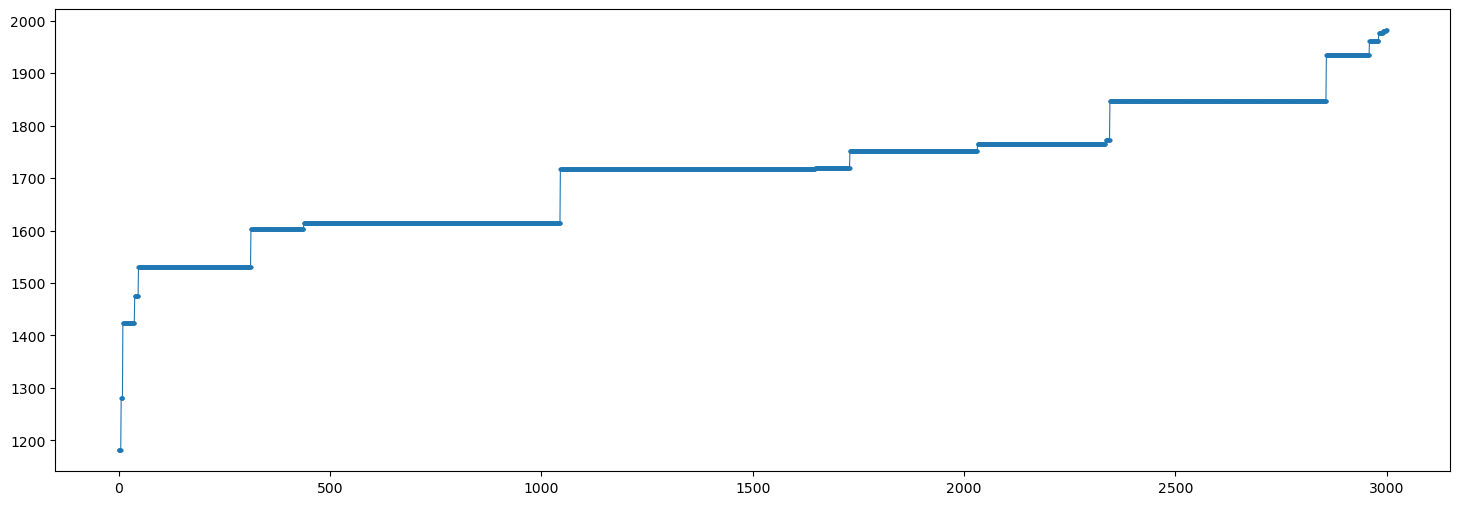

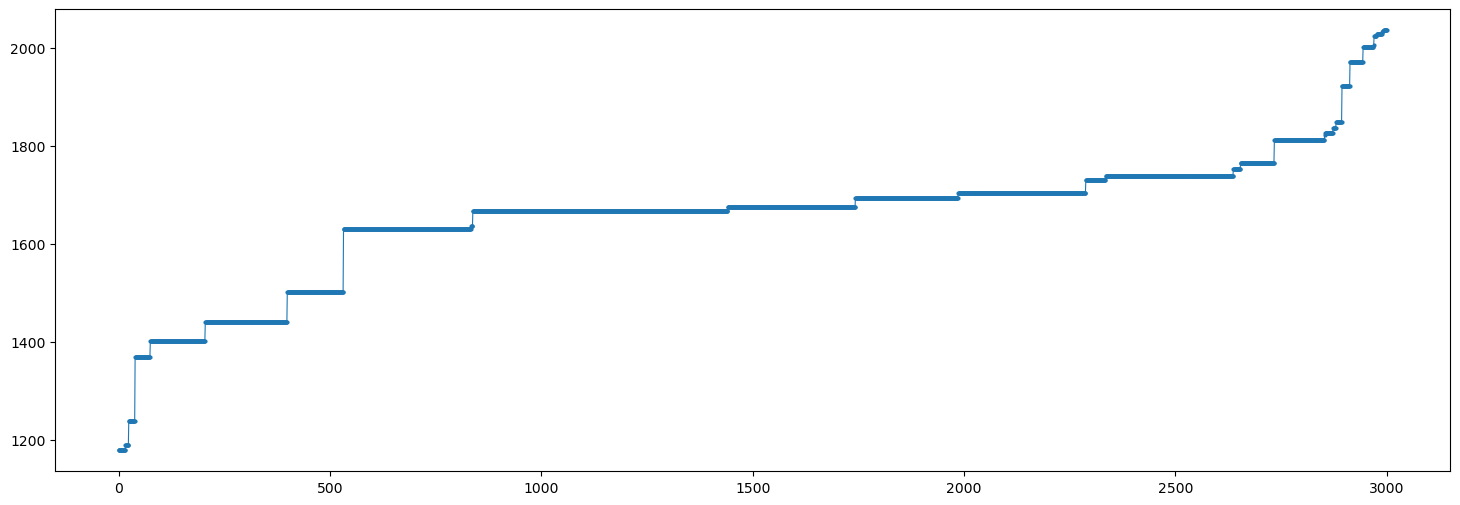

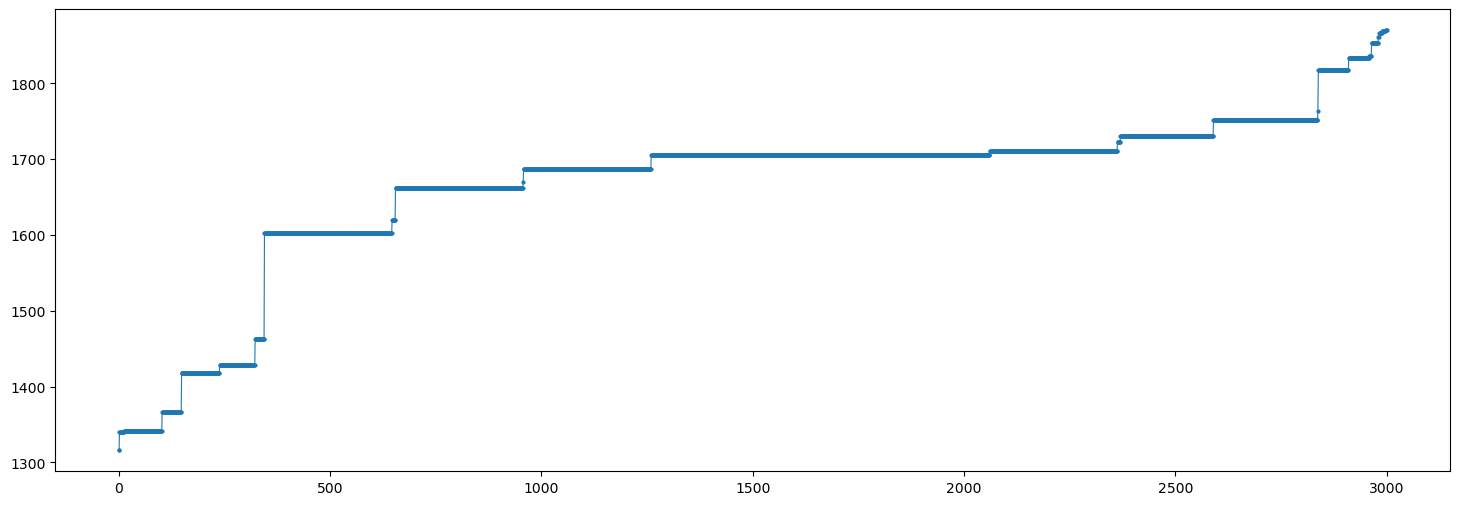

Score Test
[[405.    206.      0.509]
 [405.    213.      0.526]
 [405.    223.      0.551]
 [405.    199.      0.491]
 [405.    213.      0.526]
 [405.    205.      0.506]
 [405.    208.      0.514]
 [405.    219.      0.541]
 [405.    230.      0.568]
 [417.    219.      0.525]] 

Score Train
[[3657 3000 1855]
 [3657 3000 2021]
 [3657 3000 1960]
 [3657 3000 1981]
 [3657 3000 2036]
 [3657 3000 1830]
 [3657 3000 1902]
 [3657 3000 1982]
 [3657 3000 2036]
 [3645 3000 1870]]


In [212]:
# X48
train , test = n_fold()
perform , value , graph = execute(train , test)
print('Score Test')
print(perform , '\n')
print('Score Train')
print(value)